In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from scripts.save_figure import save_fig

In [2]:
df = pd.read_csv("/home/bishnu/project/EDA_transaction_data/data/processed/transactions_cleaned.csv",parse_dates=['transactionDateTime', 'currentExpDate','accountOpenDate'])
transaction_df = df.copy()

### What are the most common mechants and merchantCategories by transaction count and amount?

In [19]:
# Create another column named 'merchantBrand' that stores only merchant nome (not branch id)
transaction_df['merchantBrand'] = transaction_df['merchantName'].str.split('#').str[0].str.strip()
transaction_df["merchantBrand"].value_counts()

merchantBrand
AMC                 32722
EZ Putt Putt        26158
Lyft                25133
Uber                25093
gap.com             13741
                    ...  
TMobile Wireless       87
ATT                    82
Verizon Wireless       69
Duane Reed             28
My Fitness             28
Name: count, Length: 205, dtype: int64

In [49]:
total = transaction_df.merchantBrand.value_counts().sum()
df_transactioncount_per_merchant=round((transaction_df.merchantBrand.value_counts()/total)*100,4).reset_index().head(15)
df_transactioncount_per_merchant

,merchantBrand,count
0,AMC,5.1315
1,EZ Putt Putt,4.1021
2,Lyft,3.9414
3,Uber,3.9351
4,gap.com,2.1549
5,apple.com,2.1215
6,target.com,2.1196
7,alibaba.com,2.1174
8,staples.com,2.1058
9,amazon.com,2.1016


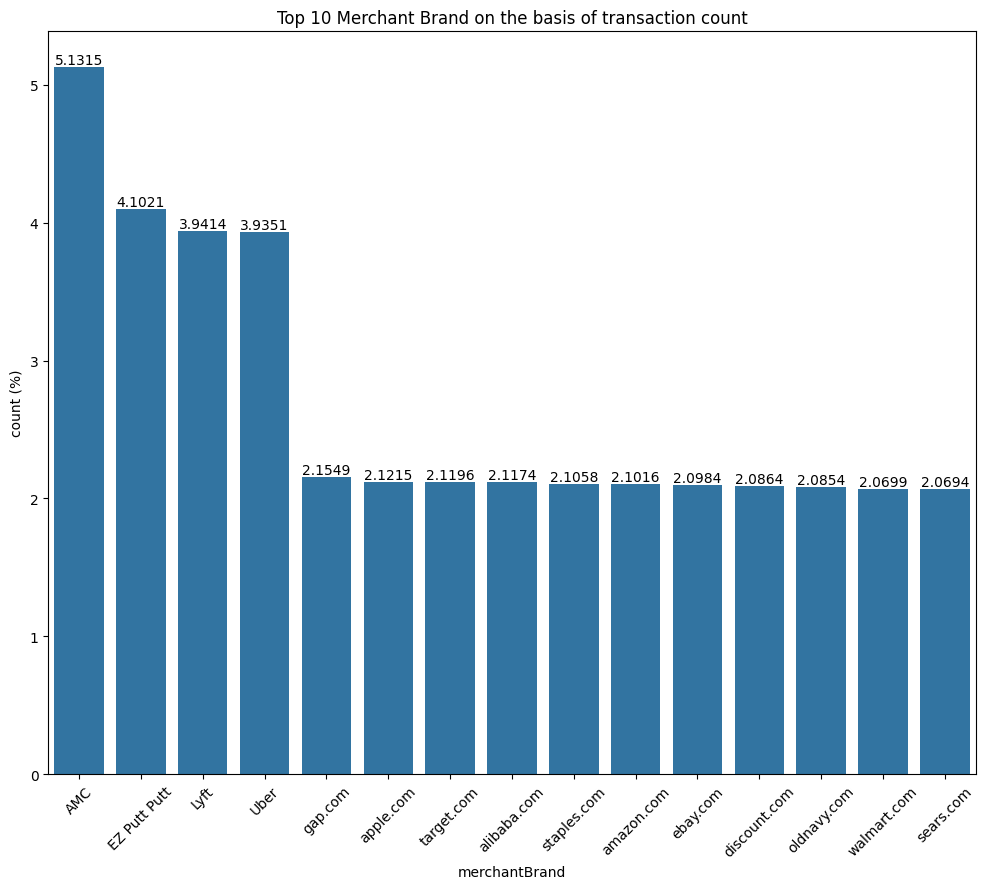

In [50]:
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactioncount_per_merchant,x="merchantBrand",y="count",order=df_transactioncount_per_merchant["merchantBrand"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("count (%)")
plt.xlabel("merchantBrand")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant Brand on the basis of transaction count")
save_fig("Top_10_Merchant_brand_(transaction_count)")
plt.show()

In [51]:
transaction_df["merchantCategoryCode"].value_counts()

merchantCategoryCode
online_retail           160474
fastfood                100572
entertainment            68655
food                     67840
rideshare                50226
online_gifts             32838
hotels                   22712
fuel                     22397
subscriptions            18258
personal care            16805
mobileapps               14500
health                   14255
online_subscriptions     11149
auto                     10073
airline                   9919
furniture                 7756
food_delivery             4936
gym                       2848
cable/phone               1453
Name: count, dtype: int64

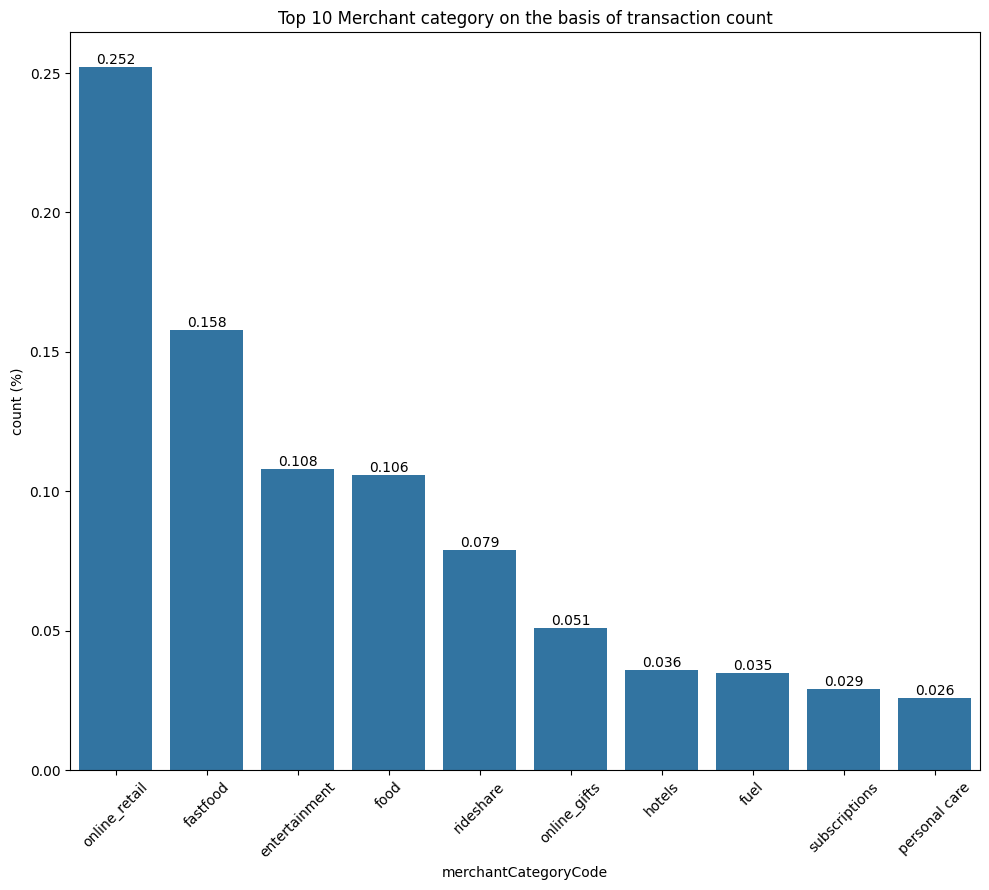

In [52]:
df_transactioncount_per_merchantcategory = round(transaction_df.merchantCategoryCode.value_counts()/total,3).reset_index().head(10)
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactioncount_per_merchantcategory,x="merchantCategoryCode",y="count",order=df_transactioncount_per_merchantcategory["merchantCategoryCode"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("count (%)")
plt.xlabel("merchantCategoryCode")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant category on the basis of transaction count")
save_fig("Top_10_merchant_category_(transaction_count)")
plt.show()

In [53]:
total_amount = transaction_df.transactionAmount.sum()
total_amount

np.float64(86202649.92000002)

In [54]:
df_transactionAmount_per_merchant = round(((transaction_df.groupby('merchantBrand')['transactionAmount'].sum().sort_values(ascending=False)/total_amount)*100),4).reset_index().head(15)

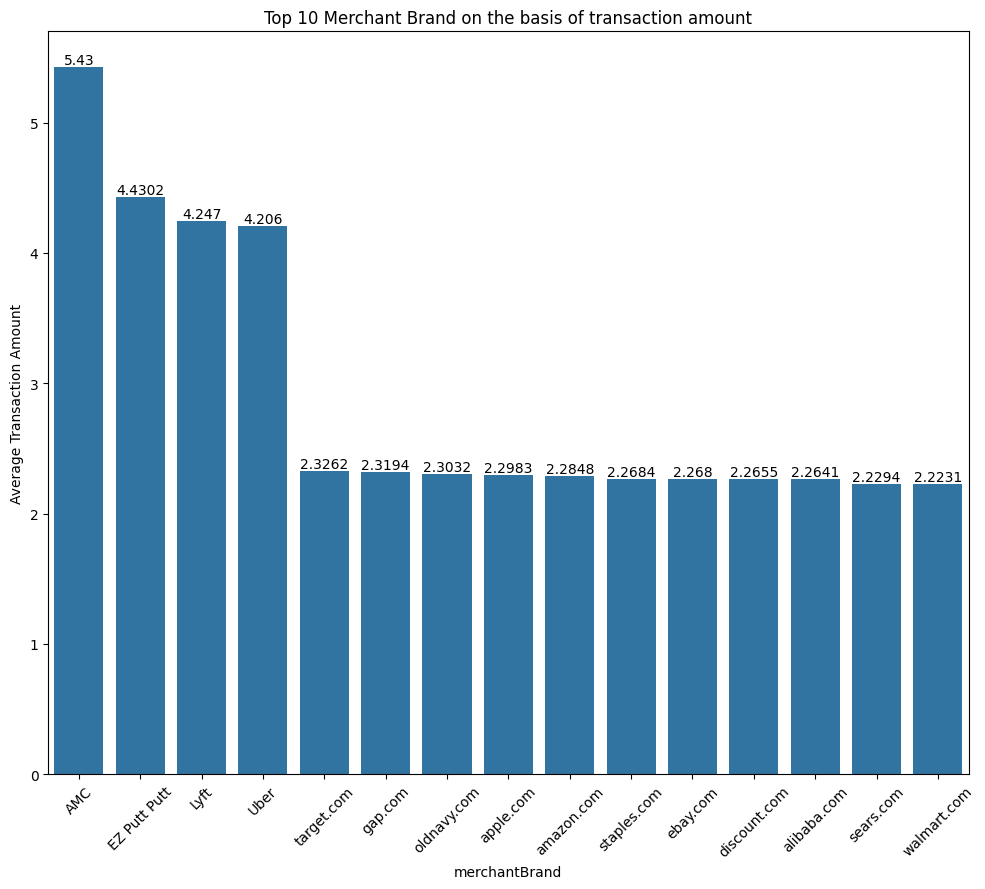

In [55]:
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactionAmount_per_merchant,x="merchantBrand",y="transactionAmount",order=df_transactionAmount_per_merchant["merchantBrand"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Average Transaction Amount")
plt.xlabel("merchantBrand")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant Brand on the basis of transaction amount")
save_fig("Top_10_Merchant_brand_(transaction_amount)")
plt.show()

In [56]:
df_transactionAmount_per_merchantcategory=round((transaction_df.groupby('merchantCategoryCode')['transactionAmount'].sum().sort_values(ascending=False)/total_amount)*100,4).reset_index().head(10)

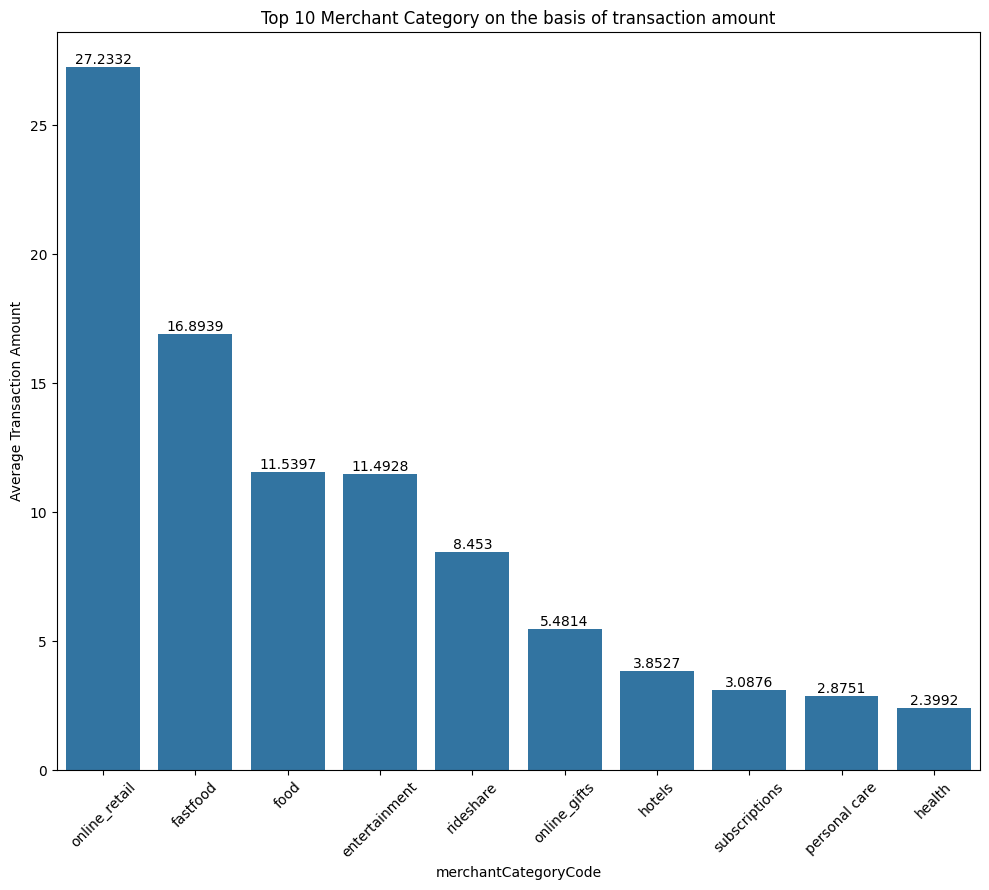

In [57]:
plt.figure(figsize=(10,9))
ax = sns.barplot(data=df_transactionAmount_per_merchantcategory,x="merchantCategoryCode",y="transactionAmount",order=df_transactionAmount_per_merchantcategory["merchantCategoryCode"])
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Average Transaction Amount")
plt.xlabel("merchantCategoryCode")
plt.xticks(rotation=45)
plt.title("Top 10 Merchant Category on the basis of transaction amount")
save_fig("Top_10_Merchant_category_(transaction_amount)")
plt.show()

Outcomes:

* Top four merchant Brands are AMC, EZ Putt Putt, Lyft, Uber on the basis of both transaction count as well as average transaction amount.
* Top Four merchant categories are online_retail, fastfood, entertainment, food on the basis of transaction count whereas the place of fastfood and entertainment gets swapped for average number of transaction.

### Is there a difference in spending behavior between fraudulent and non-fraudulent transactions?

In [58]:
fraud_stats = transaction_df.groupby('isFraud')['transactionAmount'].describe()
print(fraud_stats)

            count        mean         std  min      25%     50%       75%  \
isFraud                                                                     
False    626710.0  133.482184  145.622282  0.0  31.8200   84.42  186.5300   
True      10956.0  232.569388  190.003792  0.0  91.2775  185.36  324.5625   

             max  
isFraud           
False    1825.25  
True     1743.51  


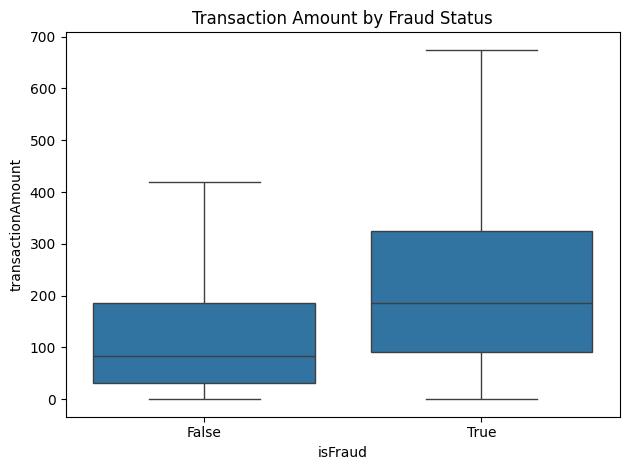

In [59]:
sns.boxplot(data=transaction_df, x='isFraud', y='transactionAmount', showfliers=False)
plt.title("Transaction Amount by Fraud Status")
save_fig("Transaction_Amount_by_Fraud_Status")
plt.show()

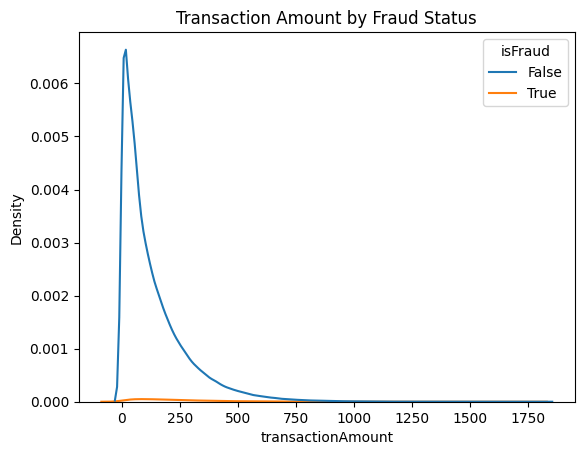

In [60]:
sns.kdeplot(data=transaction_df, x='transactionAmount',hue="isFraud")
plt.title("Transaction Amount by Fraud Status")
plt.show()

* Checking fraud detail: the average transaction amount for fradulant tranactions is quite higher (232.37) than that of non-fradulant transactions (133.48) i.e Fraud targets large transactions

### Which posEntryMode and posConditionCode combinations are more prone to fraud?

In [61]:
total_number_fraud = transaction_df[transaction_df['isFraud'] == 1].shape[0]
total_number_fraud

10956

In [62]:
grouped = transaction_df.groupby(["posEntryMode","posConditionCode"])
fraud_analysis = grouped['isFraud'].agg(
    total_transactions = 'count',
    fraud_transactions ="sum"
).reset_index()

fraud_analysis["fraud_rate"] = fraud_analysis["fraud_transactions"] / fraud_analysis["total_transactions"]
fraud_analysis_sorted = fraud_analysis.sort_values(by="fraud_rate",ascending=False)
fraud_analysis_sorted

,posEntryMode,posConditionCode,total_transactions,fraud_transactions,fraud_rate
14,90.0,99.0,200,21,0.105000
8,9.0,99.0,1799,108,0.060033
2,2.0,99.0,1451,51,0.035148
6,9.0,1.0,154694,4464,0.028857
11,80.0,99.0,125,3,0.024000
7,9.0,8.0,36434,767,0.021052
12,90.0,1.0,12961,268,0.020677
0,2.0,1.0,128560,2534,0.019711
1,2.0,8.0,30342,451,0.014864
10,80.0,8.0,2441,36,0.014748


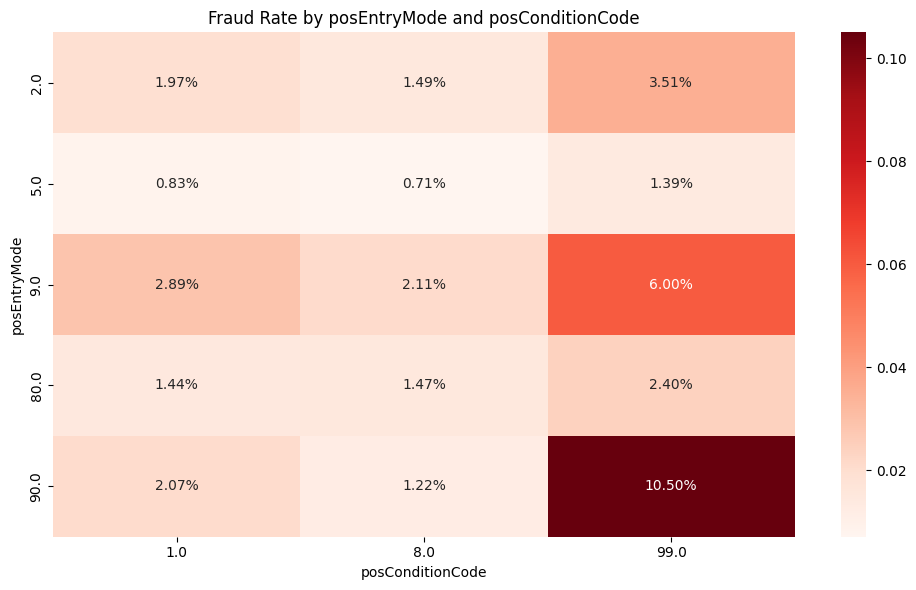

In [63]:
heatmap_data = fraud_analysis.pivot(index='posEntryMode', columns='posConditionCode', values='fraud_rate')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="Reds")
plt.title('Fraud Rate by posEntryMode and posConditionCode')
plt.ylabel('posEntryMode')
plt.xlabel('posConditionCode')
plt.tight_layout()
save_fig("Fraud_Rate_by_posEntryMode_and_posConditionCode")
plt.show()

* Combination of 90.0 posEntryMode and 99.0 posConditionCode is more prone to fraud.

### Are there specific merchant categories (merchantCategoryCode) that have higher fraud rate?

In [64]:
transaction_df["merchantCategoryCode"].value_counts()

merchantCategoryCode
online_retail           160474
fastfood                100572
entertainment            68655
food                     67840
rideshare                50226
online_gifts             32838
hotels                   22712
fuel                     22397
subscriptions            18258
personal care            16805
mobileapps               14500
health                   14255
online_subscriptions     11149
auto                     10073
airline                   9919
furniture                 7756
food_delivery             4936
gym                       2848
cable/phone               1453
Name: count, dtype: int64

In [65]:
grouped = transaction_df.groupby("merchantCategoryCode")["isFraud"].agg(
    total_transactions = 'count',
    fraud_transactions ="sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transactions"] / grouped["total_transactions"]) * 100
grouped_sorted = grouped.sort_values(by="fraud_rate",ascending=False)
grouped_sorted = grouped_sorted[~(grouped_sorted["fraud_transactions"] == 0)]
grouped_sorted

,merchantCategoryCode,total_transactions,fraud_transactions,fraud_rate
11,hotels,22712,627,2.760655
14,online_retail,160474,3525,2.196618
17,rideshare,50226,1088,2.166209
1,auto,10073,208,2.064926
5,food,67840,1362,2.007665
0,airline,9919,198,1.996169
13,online_gifts,32838,630,1.918509
10,health,14255,268,1.880042
4,fastfood,100572,1685,1.675417
3,entertainment,68655,903,1.315272


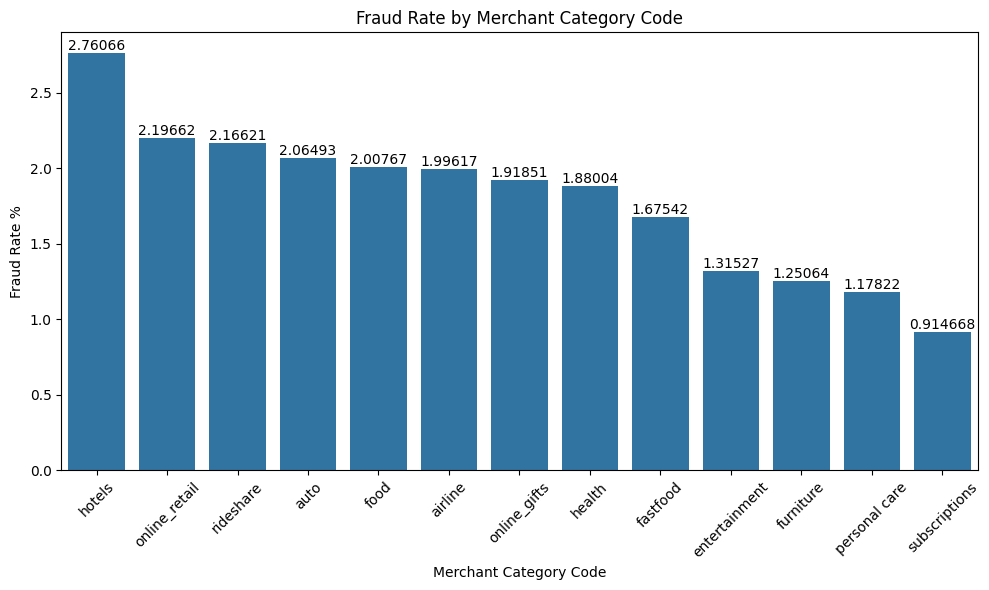

In [66]:
plt.figure(figsize=(10, 6))
ax =sns.barplot(data=grouped_sorted, x='merchantCategoryCode', y='fraud_rate')
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Fraud Rate by Merchant Category Code')
plt.ylabel('Fraud Rate %')
plt.xlabel('Merchant Category Code')
plt.xticks(rotation=45)
plt.tight_layout()
save_fig("Fraud_Rate_by_Merchant_Category_Code")
plt.show()

* Although there is no that much difference of fraud rate between merchant categories. Hotel is the common merchantCategoryCode for fraud transactions followed by online_retail.

### What is the average time gap between accountOpenDate and transactionDateTime for fraudulent transactions?

In [5]:
transaction_df["gap_accOpen_transDateTime"] = (transaction_df["transactionDateTime"] - transaction_df["accountOpenDate"]).dt.days

In [6]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]
fraud_df = fraud_df.sort_values(["accountNumber", "transactionDateTime"])

In [7]:
first_fraud_per_account = fraud_df.groupby("accountNumber").first().reset_index()
first_fraud_per_account

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,gap_accOpen_transDateTime
0,100547107,100547107,2500,2408.37,2016-04-02 20:23:39,286.07,Tim Hortons #911569,US,US,2.0,...,PURCHASE,True,91.63,True,False,0,20,4,2,1616
1,101680180,101680180,15000,11035.78,2016-11-02 13:22:04,311.71,walmart.com,US,US,2.0,...,PURCHASE,True,3964.22,False,False,0,13,11,2,493
2,102307135,102307135,20000,18682.20,2016-12-16 20:57:58,64.92,Universe Massage #357768,US,US,9.0,...,PURCHASE,True,1317.80,True,False,0,20,12,16,867
3,102635965,102635965,1000,996.90,2016-06-08 10:38:24,209.02,Regal Cinemas #05791,US,US,2.0,...,PURCHASE,True,3.10,True,False,0,10,6,8,283
4,103893403,103893403,7500,7174.28,2016-05-03 14:58:34,111.76,Burger King #15452,US,US,2.0,...,PURCHASE,True,325.72,True,False,0,14,5,3,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,997379599,997379599,5000,1324.59,2016-01-26 19:36:10,679.56,Next Day eCards,US,US,2.0,...,PURCHASE,True,3675.41,False,False,0,19,1,26,1451
2263,998480579,998480579,5000,5000.00,2016-02-09 00:56:50,140.62,ebay.com,US,US,9.0,...,PURCHASE,True,0.00,False,False,0,0,2,9,204
2264,998837644,998837644,5000,1738.26,2016-08-06 10:15:52,314.97,walmart.com,US,US,9.0,...,PURCHASE,True,3261.74,False,False,0,10,8,6,677
2265,999275549,999275549,50000,48677.75,2016-06-19 15:59:45,89.14,amazon.com,US,US,9.0,...,PURCHASE,True,1322.25,False,False,0,15,6,19,231


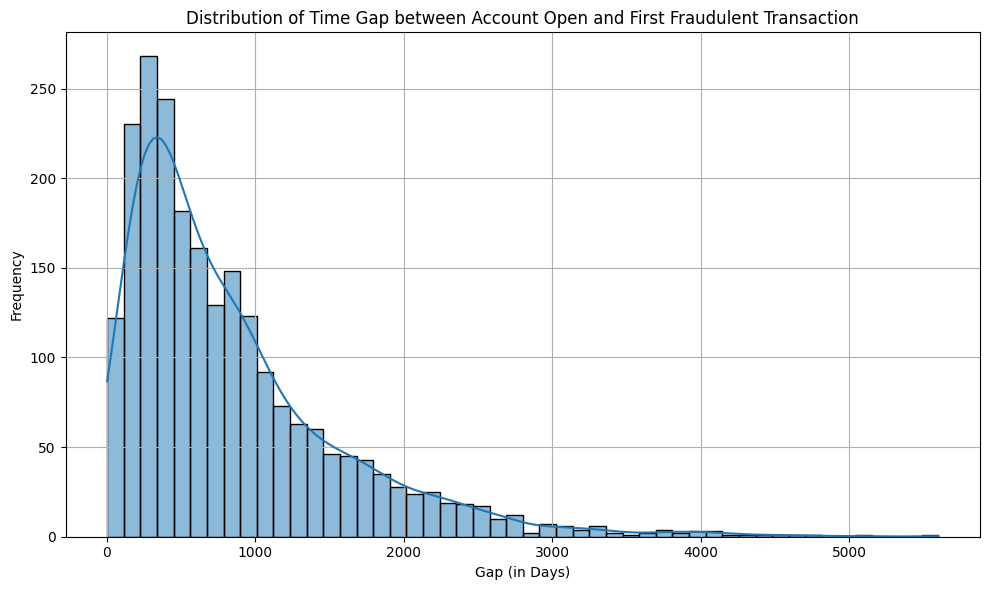

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(first_fraud_per_account["gap_accOpen_transDateTime"], bins=50, kde=True)
plt.title("Distribution of Time Gap between Account Open and First Fraudulent Transaction")
plt.xlabel("Gap (in Days)")
plt.ylabel("Frequency")
plt.grid(True)
save_fig("Distribution_of_Time_Gap_between_Account_Open_and_First_Fraudulent_Transaction")
plt.show()

In [9]:
average_gap= first_fraud_per_account["gap_accOpen_transDateTime"].mean()
print(f"Average Time Gap: {average_gap:.2f} days")
med_gap = first_fraud_per_account["gap_accOpen_transDateTime"].median()
print(f"Median Time Gap: {med_gap:.2f} days")

Average Time Gap: 840.89 days
Median Time Gap: 621.00 days


In [10]:
transaction_df[transaction_df["isFraud"] == 1]["accountNumber"].nunique()

2267

In [11]:
first_fraud_per_account["gap_accOpen_transDateTime"].describe()

count    2267.000000
mean      840.891045
std       736.353935
min         2.000000
25%       317.000000
50%       621.000000
75%      1123.000000
max      5599.000000
Name: gap_accOpen_transDateTime, dtype: float64

* Average Time Gap: 840.89 days
* Median Time Gap: 621.00 days
* Number of account associated with fraud transaction : 2267
* Min gap, max gap: 2 days, 5599 days

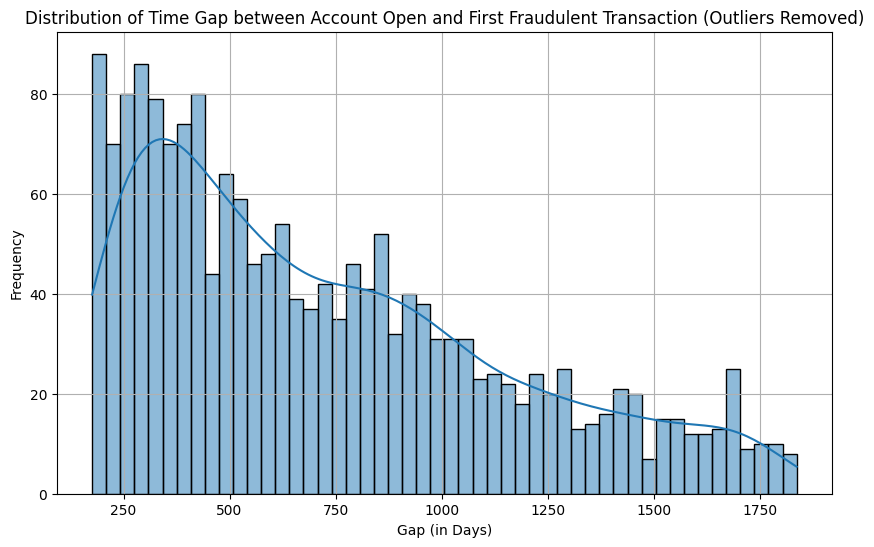

In [14]:
# cutting 10% outliers
lower_bound = first_fraud_per_account["gap_accOpen_transDateTime"].quantile(0.1)
upper_bound = first_fraud_per_account["gap_accOpen_transDateTime"].quantile(0.9)
filtered_df = first_fraud_per_account[(first_fraud_per_account["gap_accOpen_transDateTime"] >= lower_bound) & (first_fraud_per_account["gap_accOpen_transDateTime"] <= upper_bound)]
plt.figure(figsize=(10,6))
sns.histplot(filtered_df["gap_accOpen_transDateTime"], bins=50, kde=True)
plt.title("Distribution of Time Gap between Account Open and First Fraudulent Transaction (Outliers Removed)")
plt.xlabel("Gap (in Days)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [15]:
filtered_df["gap_accOpen_transDateTime"].describe()

count    1813.000000
mean      722.214010
std       426.142151
min       176.000000
25%       366.000000
50%       621.000000
75%       990.000000
max      1837.000000
Name: gap_accOpen_transDateTime, dtype: float64

In [16]:
transaction_df["gap_accOpen_transDateTime"]

0         523
1         524
2         526
3         526
4         531
         ... 
637661    396
637662    401
637663    408
637664    411
637665    420
Name: gap_accOpen_transDateTime, Length: 637666, dtype: int64

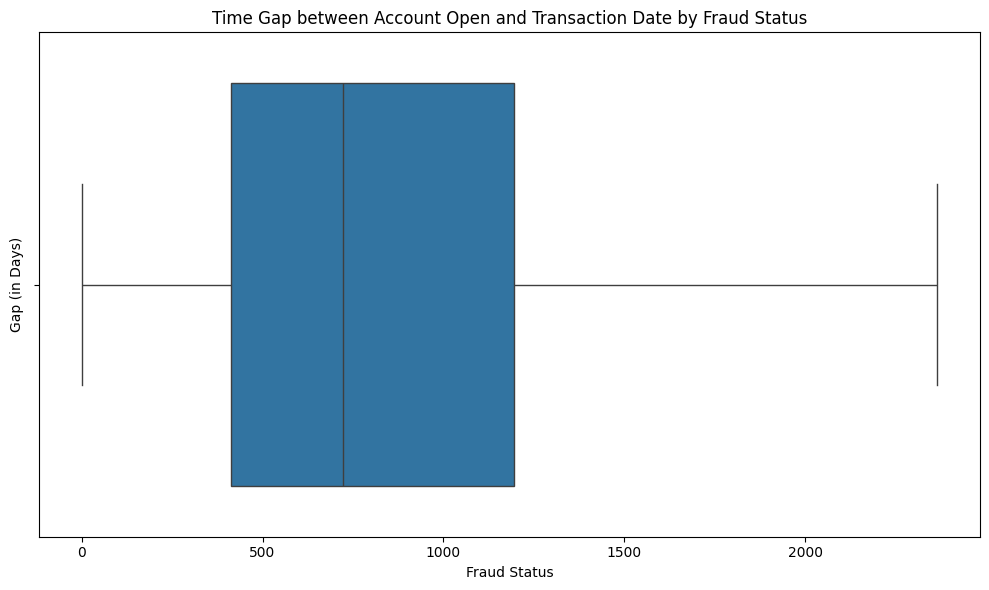

In [20]:
#box plot 
plt.figure(figsize=(10, 6))
sns.boxplot(data=transaction_df, x='gap_accOpen_transDateTime', showfliers=False)
plt.title("Time Gap between Account Open and Transaction Date by Fraud Status")
plt.ylabel("Gap (in Days)")
plt.xlabel("Fraud Status")
plt.tight_layout()
plt.show()

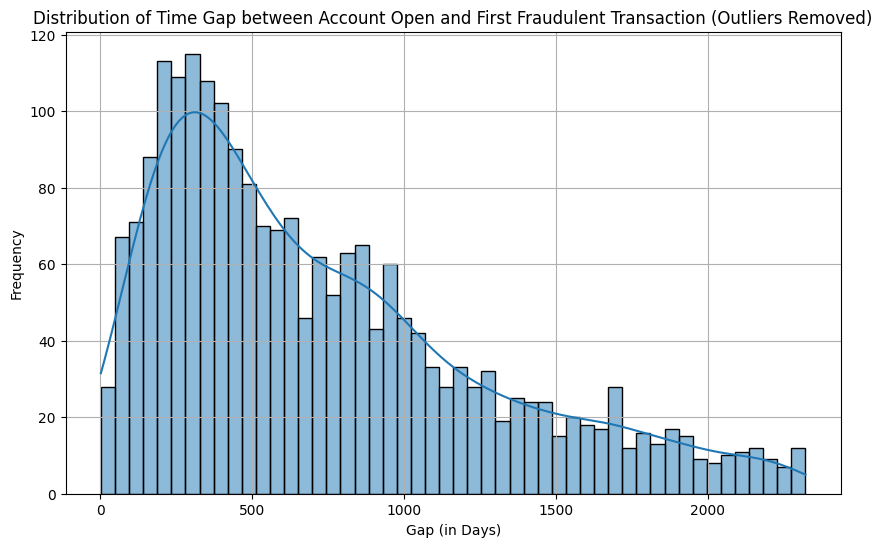

In [18]:
#use IQR method to remove outliers
Q1 = first_fraud_per_account["gap_accOpen_transDateTime"].quantile(0.25)
Q3 = first_fraud_per_account["gap_accOpen_transDateTime"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = first_fraud_per_account[(first_fraud_per_account["gap_accOpen_transDateTime"] >= lower_bound) & (first_fraud_per_account["gap_accOpen_transDateTime"] <= upper_bound)]
plt.figure(figsize=(10,6))
sns.histplot(filtered_df["gap_accOpen_transDateTime"], bins=50, kde=True)       
plt.title("Distribution of Time Gap between Account Open and First Fraudulent Transaction (Outliers Removed)")
plt.xlabel("Gap (in Days)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [21]:
filtered_df["gap_accOpen_transDateTime"].describe()

count    2157.000000
mean      729.645804
std       539.332371
min         2.000000
25%       306.000000
50%       583.000000
75%      1019.000000
max      2321.000000
Name: gap_accOpen_transDateTime, dtype: float64

### Do mismatches in cardCVV vs. enteredCVV and currentExpDate vs. expirationDateKeyInMatch correlate with fraud?

In [22]:
transaction_df["expirationDateKeyInMatch"].value_counts()

expirationDateKeyInMatch
False    636703
True        963
Name: count, dtype: int64

In [23]:
transaction_df[["cardCVV","enteredCVV","currentExpDate","expirationDateKeyInMatch"]]

,cardCVV,enteredCVV,currentExpDate,expirationDateKeyInMatch
0,492,492,2020-04-01,False
1,492,492,2023-06-01,False
2,492,492,2027-12-01,False
3,492,492,2029-09-01,False
4,492,492,2024-10-01,False
...,...,...,...,...
637661,127,127,1930-01-01,False
637662,127,127,2026-05-01,False
637663,127,127,2019-10-01,False
637664,127,127,2029-11-01,False


In [24]:
transaction_df["cvv_mismatch"] = transaction_df["cardCVV"] != transaction_df["enteredCVV"]
transaction_df["date_mismatch"] = transaction_df["expirationDateKeyInMatch"] == 0

In [25]:
cvv_table = pd.crosstab(transaction_df["cvv_mismatch"],transaction_df["isFraud"])
cvv_table

isFraud,False,True
cvv_mismatch,,
False,620994,10768
True,5716,188


In [26]:
exp_table = pd.crosstab(transaction_df["date_mismatch"],transaction_df["isFraud"])
exp_table

isFraud,False,True
date_mismatch,,
False,950,13
True,625760,10943


In [29]:
fraud_rates = transaction_df.groupby("cvv_mismatch")["isFraud"].mean()
print(fraud_rates*100)
fraud_rates = transaction_df.groupby("date_mismatch")["isFraud"].mean()
print(fraud_rates*100)

cvv_mismatch
False    1.704439
True     3.184282
Name: isFraud, dtype: float64
date_mismatch
False    1.349948
True     1.718698
Name: isFraud, dtype: float64


In [83]:
from scipy.stats import chi2_contingency

In [84]:
chi2_cvv, p_cvv, _ ,_= chi2_contingency(cvv_table)
chi2_exp, p_exp, _, _ = chi2_contingency(exp_table)

In [85]:
if p_cvv < 0.05:
    print("There is a significant association between cvv_mismatch and fraud.")
else:
    print("There is no significant association between cvv_mismatch and fraud.")

if p_exp < 0.05:
    print("There is a significant association between expiration date mismatch and fraud.")
else:
    print("There is no significant association between expiration date mismatch and fraud.")

There is a significant association between cvv_mismatch and fraud.
There is no significant association between expiration date mismatch and fraud.


* There is a significant association between cvv_mismatch and fraud.
* There is no significant association between expiration date mismatch and fraud.

### Is there a correlation between creditLimit, availableMoney, and currentBalance?

In [86]:
columns = ["creditLimit","availableMoney","currentBalance"]
subset_df = transaction_df[columns]

correlation_matrix = subset_df.corr()
correlation_matrix

,creditLimit,availableMoney,currentBalance
creditLimit,1.000000,0.856377,0.598408
availableMoney,0.856377,1.000000,0.098767
currentBalance,0.598408,0.098767,1.000000


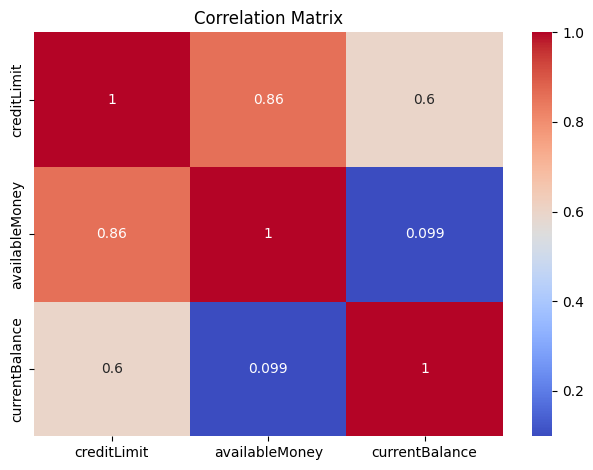

In [87]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
save_fig("Correlation_Matrix(creditLimit_availableMoney_currentBalance)")
plt.show()

In [88]:
transaction_df[["transactionAmount","availableMoney"]].corr()

,transactionAmount,availableMoney
transactionAmount,1.0000,-0.0116
availableMoney,-0.0116,1.0000


* Positive correlation between creditLimit and availableMoney , it means accounts with high limits also tends to have more available money.
* Same for creditLimit and currentBalance
* But there is negligible correlation between available money and current Balance and same for transation amount and available money.

### Do fraudulent transactions tend to have a certain transactionType or cardPresent flag?

In [89]:
grouped_txn_type = transaction_df.groupby(["transactionType"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped_txn_type["fraud_rate"] = (grouped_txn_type["fraud_transaction"] / grouped_txn_type["total_transactions"])* 100
grouped_txn_type

,transactionType,total_transactions,fraud_transaction,fraud_rate
0,ADDRESS_VERIFICATION,16374,87,0.531330
1,PURCHASE,605224,10581,1.748278
2,REVERSAL,16068,288,1.792382


In [90]:
grouped_cardPresent_type = transaction_df.groupby(["cardPresent"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped_cardPresent_type["fraud_rate"] = (grouped_cardPresent_type["fraud_transaction"] / grouped_cardPresent_type["total_transactions"])* 100
grouped_cardPresent_type

,cardPresent,total_transactions,fraud_transaction,fraud_rate
0,False,338178,6406,1.894269
1,True,299488,4550,1.519260


In [30]:
pd.pivot_table(transaction_df, index=["transactionType"], columns=["cardPresent"], values="isFraud", aggfunc="mean")

cardPresent,False,True
transactionType,,
ADDRESS_VERIFICATION,0.005313,NaN
PURCHASE,0.019615,0.015193
REVERSAL,0.020437,0.015159


In [ ]:
transaction_df["transactionType" == "ADDRESS_VERIFICATION"].value_counts()

* There is no sigificant flag based on transaction type for fraud transactions, but address_verification has lowest rate of fraud.
* Presence of card is less prone to fraud compare to no card.

### Are there repeated frauds from the same customerId or accountNumber? What are their patterns?

In [35]:
grouped_accountNumber = transaction_df.groupby(["accountNumber"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped_accountNumber["fraud_rate"] = round((grouped_accountNumber["fraud_transaction"] / grouped_accountNumber["total_transactions"])* 100,4)
grouped_accountNumber.sort_values(by=["total_transactions","fraud_transaction"],ascending=False).head(10)
# grouped_accountNumber.sort_values(by=["fraud_rate"],ascending=False).head(10)


,accountNumber,total_transactions,fraud_transaction,fraud_rate
1205,318001076,9977,279,2.7964
1978,456044564,8339,94,1.1272
3945,812328116,5461,42,0.7691
4101,838085703,5099,57,1.1179
766,239875038,4671,64,1.3702
4325,877017103,4408,78,1.7695
994,278064853,4201,73,1.7377
1406,353215513,3729,203,5.4438
1185,314506271,3382,44,1.3010
4555,917216469,3237,38,1.1739


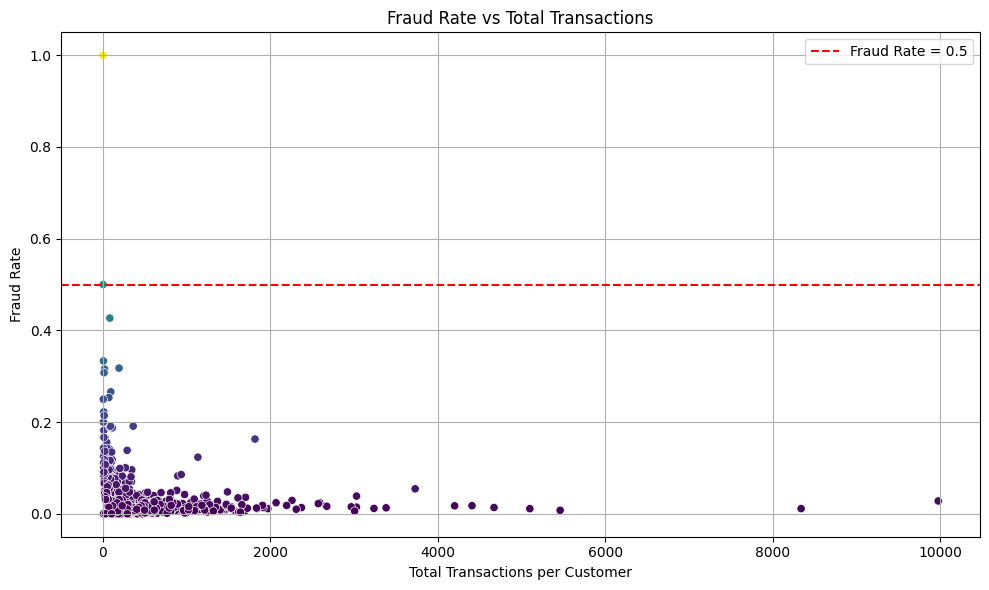

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group your transaction data by customerID or accountNumber
grouped = df.groupby('accountNumber').agg(
    total_txns=('isFraud', 'count'),
    fraud_txns=('isFraud', 'sum')
).reset_index()
grouped['fraud_rate'] = grouped['fraud_txns'] / grouped['total_txns']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped, x='total_txns', y='fraud_rate', hue='fraud_rate', palette='viridis', legend=False)
plt.axhline(0.5, color='red', linestyle='--', label='Fraud Rate = 0.5')
plt.xlabel("Total Transactions per Customer")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate vs Total Transactions")
plt.grid(True)
plt.legend()
plt.tight_layout()
save_fig("Fraud_Rate_vs_Total_Transactions_per_Customer")
plt.show()


In [33]:
grouped["total_txns"].describe()

count    5000.000000
mean      127.533200
std       341.447249
min         1.000000
25%        21.000000
50%        47.000000
75%       107.000000
max      9977.000000
Name: total_txns, dtype: float64

###  Do certain customers have repeated fraud history?


In [102]:
fraud_per_customer = transaction_df[transaction_df["isFraud"] == 1]["customerId"].value_counts().head(5).reset_index()

In [ ]:
ax = sns.barplot(data=fraud_per_customer, x="customerId", y="count", order=fraud_per_customer["customerId"])
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Top 5 Customers with Most Fraudulent Transactions")
plt.ylabel("Fraud Count")
plt.xlabel("Customer ID")
plt.xticks(rotation=45)
save_fig("Top_5_Customers_with_Most_Fraudulent_Transactions")
plt.show()

## Is there a pattern between low availableMoney and fraud?


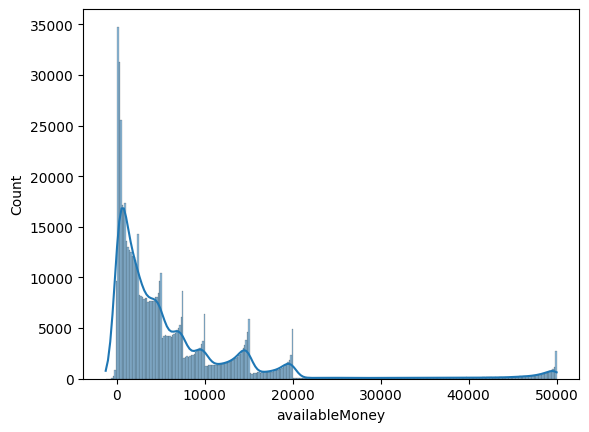

In [106]:
sns.histplot(transaction_df["availableMoney"], kde=True)
plt.show()

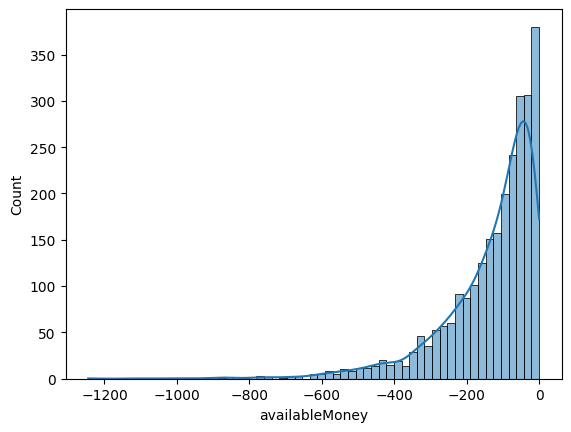

In [110]:
sns.histplot(transaction_df[transaction_df["availableMoney"] < 0]["availableMoney"], kde=True)
plt.show()

In [113]:
fraud_availableMoney = transaction_df[transaction_df["isFraud"] == 1]["availableMoney"]
fraud_availableMoney

0          5000.00
3          4676.52
72         2730.06
79         2394.36
84          910.91
            ...   
637380     5802.15
637545    34545.80
637565    33255.25
637623     6448.10
637627     5756.53
Name: availableMoney, Length: 10956, dtype: float64

In [114]:
non_fraud_availableMoney = transaction_df[transaction_df["isFraud"] == 0]["availableMoney"]
non_fraud_availableMoney

1         4888.67
2         4863.92
4         4449.18
5         4449.18
6         4439.38
           ...   
637661    2574.02
637662    2568.65
637663    2344.95
637664    2206.53
637665    2190.22
Name: availableMoney, Length: 626710, dtype: float64

In [115]:
transaction_df[(transaction_df["isFraud"] == 1) & (transaction_df["availableMoney"] < 0)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand,gap_accOpen_transDateTime,cvv_mismatch,date_mismatch
5581,398189423,398189423,250,-56.34,2016-04-27 16:46:39,103.43,Boston Cafe #465229,US,US,2.0,...,True,False,0,16,4,27,Boston Cafe,1414,False,True
13718,824423647,824423647,2500,-70.52,2016-09-19 06:24:50,192.37,AMC #724446,US,US,9.0,...,True,False,0,6,9,19,AMC,759,False,True
24310,772212779,772212779,250,-17.31,2016-08-20 01:26:35,229.99,Boston Cafe #592935,US,US,2.0,...,True,False,0,1,8,20,Boston Cafe,238,False,True
24525,772212779,772212779,250,-131.93,2016-09-18 01:03:35,268.33,John's Bistro,US,US,9.0,...,True,False,0,1,9,18,John's Bistro,267,False,True
52484,235582160,235582160,250,-894.64,2016-07-28 13:34:59,127.75,Uber,US,US,9.0,...,False,False,0,13,7,28,Uber,834,False,True
63395,545561356,545561356,2500,-62.33,2016-07-24 21:06:47,320.18,CVS #618160,US,US,9.0,...,False,False,0,21,7,24,CVS,843,False,True
101630,685565993,685565993,250,-269.83,2016-12-22 16:29:05,125.87,EZ Putt Putt #755869,US,US,9.0,...,True,False,0,16,12,22,EZ Putt Putt,1077,False,True
106699,513829169,513829169,250,-95.92,2016-12-30 11:25:45,231.71,1st BBQ,US,US,9.0,...,True,False,0,11,12,30,1st BBQ,2859,False,True
124334,314112573,314112573,250,-44.15,2016-09-27 19:16:09,549.27,AMC #724446,US,US,9.0,...,False,False,0,19,9,27,AMC,681,False,True
179257,341256661,341256661,250,-125.51,2016-02-14 22:08:16,28.36,Best Bistro #262998,US,US,5.0,...,True,False,0,22,2,14,Best Bistro,720,False,True


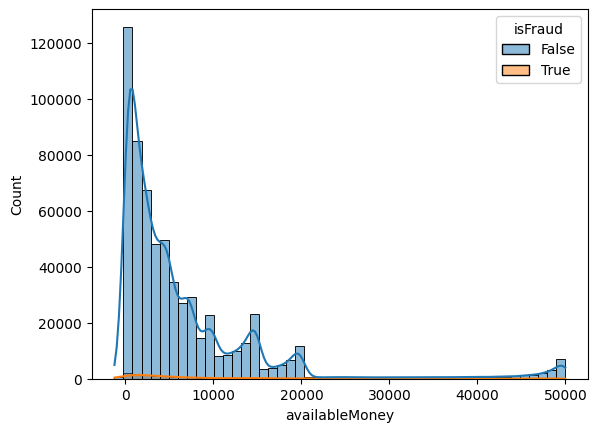

In [121]:
sns.histplot(data = transaction_df,x = "availableMoney", kde=True, hue=transaction_df["isFraud"], bins=50)
plt.show()

In [122]:
transaction_df["availableMoney"].describe()


count    637666.000000
mean       6652.259023
std        9227.524734
min       -1244.930000
25%        1115.270000
50%        3577.325000
75%        8163.632500
max       50000.000000
Name: availableMoney, dtype: float64

In [36]:
bins =[-2000,0,10000,20000,30000,40000,50000]
labels = ["Negative (-2000 to 0)","Very Low (0 to 10000)","Low (10000 to 20000)","Medium (20000 to 30000)","High (30000 to 40000)","Very High (40000 to 50000)"]
transaction_df["availableMoney_category"] = pd.cut(transaction_df["availableMoney"], bins=bins, labels=labels)

fraud_rate_per_bin = transaction_df.groupby('availableMoney_category')["isFraud"].mean().sort_index()
fraud_rate_per_bin


/tmp/ipykernel_6676/2789347701.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_per_bin = transaction_df.groupby('availableMoney_category')["isFraud"].mean().sort_index()


availableMoney_category
Negative (-2000 to 0)         0.013117
Very Low (0 to 10000)         0.017144
Low (10000 to 20000)          0.017858
Medium (20000 to 30000)       0.021264
High (30000 to 40000)         0.019185
Very High (40000 to 50000)    0.013600
Name: isFraud, dtype: float64

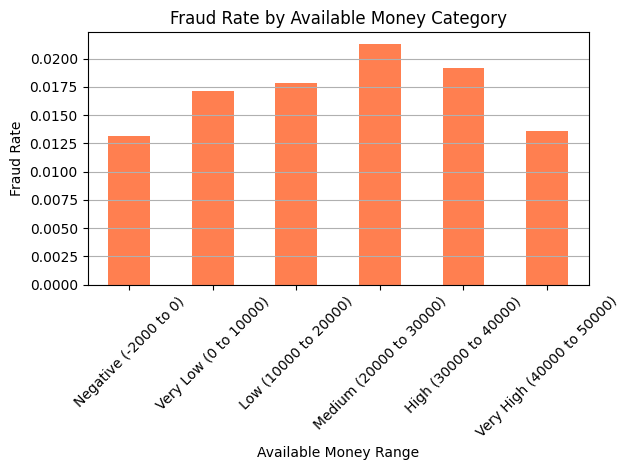

In [37]:
fraud_rate_per_bin.plot(kind="bar", color="coral")
plt.title("Fraud Rate by Available Money Category")
plt.ylabel("Fraud Rate")
plt.xlabel("Available Money Range")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
save_fig("Fraud_Rate_by_Available_Money_Category")
plt.show()

In [128]:
pos_availableMoney = transaction_df[transaction_df["availableMoney"] >= 0]
neg_availableMoney = transaction_df[transaction_df["availableMoney"] < 0]

In [130]:
pos_availableMoney.groupby("isFraud")["availableMoney"].count()

isFraud
False    624152
True      10922
Name: availableMoney, dtype: int64

In [131]:
neg_availableMoney.groupby("isFraud")["availableMoney"].count()

isFraud
False    2558
True       34
Name: availableMoney, dtype: int64

In [38]:
fraud = transaction_df[transaction_df["isFraud"] == 1]["availableMoney"]
non_fraud = transaction_df[transaction_df["isFraud"] == 0]["availableMoney"]

In [39]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(fraud, non_fraud, alternative='two-sided')
print(f"Statistic = {stat}, p-value = {p}")
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: The distributions are different.")
else:
    print("Fail to reject the null hypothesis: The distributions are similar.")

Statistic = 3468952400.0, p-value = 0.0606495946941368
Fail to reject the null hypothesis: The distributions are similar.


* Medium amount (20000 to 30000) of availableMoney has higher fraud rate (i.e 0.212)
* Only 34 fraud transactions are done by user having negative available money.

## Are customers with high credit limits more/less likely to face fraud?


In [133]:
transaction_df["creditLimit"].value_counts()

creditLimit
5000     126186
7500     104719
15000     91282
10000     67017
20000     63864
2500      59053
50000     37796
500       32490
1000      27661
250       27598
Name: count, dtype: int64

In [134]:
transaction_df[transaction_df["isFraud"] == 1]["creditLimit"].value_counts()

creditLimit
5000     2158
7500     2067
15000    1563
20000    1183
10000    1159
2500      903
50000     643
500       457
1000      424
250       399
Name: count, dtype: int64

In [135]:
grouped = transaction_df.groupby(["creditLimit"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["total_transactions"])* 100

In [138]:
grouped[["creditLimit","fraud_rate"]]

,creditLimit,fraud_rate
0,250,1.445757
1,500,1.406587
2,1000,1.532844
3,2500,1.529135
4,5000,1.710174
5,7500,1.973854
6,10000,1.729412
7,15000,1.712276
8,20000,1.852374
9,50000,1.701238


In [139]:
# Perform a chi-square test
chi2_creditLimit, p_creditLimit, _, _ = chi2_contingency(pd.crosstab(transaction_df["creditLimit"], transaction_df["isFraud"]))
if p_creditLimit < 0.05:
    print("There is a significant association between creditLimit and fraud.")
else:
    print("There is no significant association between creditLimit and fraud.")

There is a significant association between creditLimit and fraud.


In [41]:
from scipy.stats import mannwhitneyu

# Separate the two groups
fraud_available_money = transaction_df[transaction_df["isFraud"] == 1]["availableMoney"]
nonfraud_available_money = transaction_df[transaction_df["isFraud"] == 0]["availableMoney"]

stat, p_value = mannwhitneyu(fraud_available_money, nonfraud_available_money, alternative='two-sided')

print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Result: Significant difference between fraud and non-fraud availableMoney distributions (reject H0)")
else:
    print("Result: No significant difference between fraud and non-fraud availableMoney distributions (fail to reject H0)")


P-value: 0.0606495946941368
Result: No significant difference between fraud and non-fraud availableMoney distributions (fail to reject H0)


* Almost all creditlimit classes has same fraud_rate. creditlimit (7500) topped.
* Chi-square test shows: There is a significant association between creditLimit and fraud.
* Mann-Whitney U statistics test shows: No significant difference between fraud and non-fraud availableMoney distributions

* Mann-Whitney U test checks whether there is a difference between two independent groups.
* Non-parametric counterpart to the t-test for independent samples. 
* Is there a difference in the rank sum?

## What's the average balance difference (available vs current) in fraudulent cases?

In [ ]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]


In [17]:
fraud_pos_df = fraud_df[fraud_df["availableMoney"] >= 0]
fraud_pos_df["balance_difference"] = fraud_pos_df["currentBalance"] - fraud_pos_df["availableMoney"]

# Calculate average balance difference
average_difference = fraud_pos_df["balance_difference"].mean()

print(f"Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only positive availableMoney): {average_difference:.2f}")

Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only positive availableMoney): -2133.82


/tmp/ipykernel_142631/2082427880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_pos_df["balance_difference"] = fraud_pos_df["currentBalance"] - fraud_pos_df["availableMoney"]


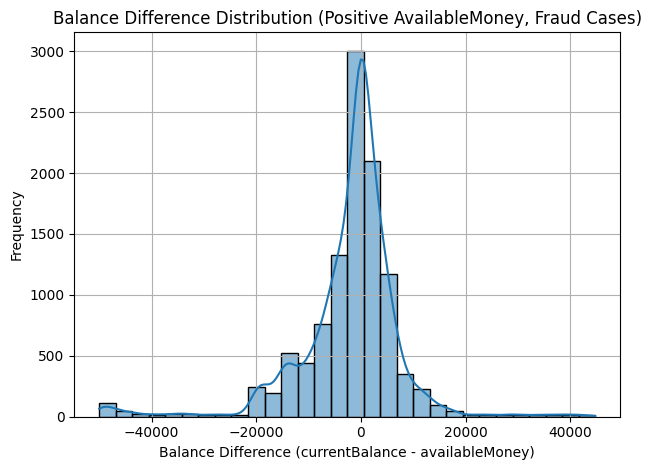

In [18]:
sns.histplot(fraud_pos_df["balance_difference"], bins=30, kde=True)
plt.title("Balance Difference Distribution (Positive AvailableMoney, Fraud Cases)")
plt.xlabel("Balance Difference (currentBalance - availableMoney)")
plt.ylabel("Frequency")
plt.grid(True)
save_fig("Balance_Difference_Distribution_Fraud_Cases_positive(currentBalance - availableMoney)")
plt.show()

In [19]:
fraud_neg_df = fraud_df[fraud_df["availableMoney"] < 0]
fraud_neg_df["balance_difference"] = fraud_neg_df["currentBalance"] - fraud_neg_df["availableMoney"]

# Calculate average balance difference
average_difference = fraud_neg_df["balance_difference"].mean()

print(f"Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only negative availableMoney): {average_difference:.2f}")

Average balance difference (currentBalance - availableMoney) in fraudulent transactions (only negative availableMoney): 797.83


/tmp/ipykernel_142631/1658170179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_neg_df["balance_difference"] = fraud_neg_df["currentBalance"] - fraud_neg_df["availableMoney"]


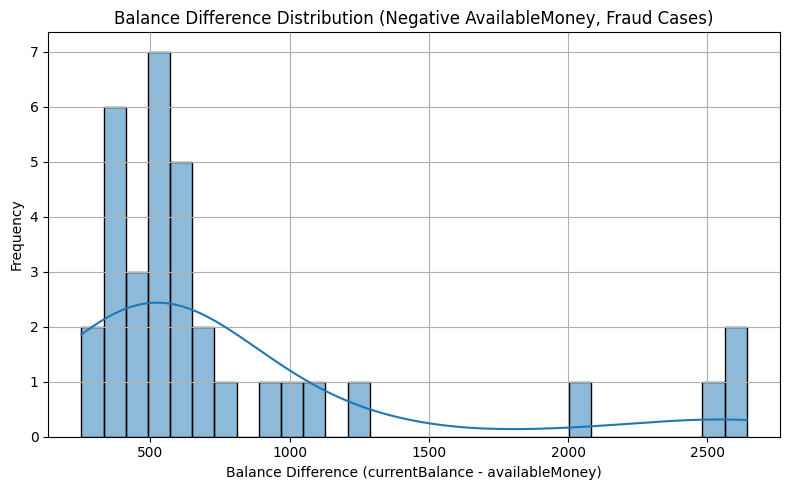

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(fraud_neg_df["balance_difference"], bins=30, kde=True)
plt.title("Balance Difference Distribution (Negative AvailableMoney, Fraud Cases)")
plt.xlabel("Balance Difference (currentBalance - availableMoney)")
plt.ylabel("Frequency")
plt.grid(True)
save_fig("Balance_Difference_Distribution_Fraud_Cases_negative(currentBalance - availableMoney)")
plt.show()

* When available money is negative, the fraud cases mostly involve moderate balance difference.
* When available money is positive, the fraud cases are more variable, many fraud cases involve small balance manipulation.
* There are some extreme outliers, which could represent bigger fraud attemps.

## Does posEntryMode + cardPresent combo indicate more fraud?

In [23]:
transaction_df["cardPresent"].value_counts()

cardPresent
False    338178
True     299488
Name: count, dtype: int64

In [24]:
transaction_df["posEntryMode"].value_counts()

posEntryMode
5.0     255283
9.0     192927
2.0     160353
90.0     16204
80.0     12899
Name: count, dtype: int64

In [27]:
fraud_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day', 'balance_difference', 'availableMoney_sign'],
      dtype='object')

In [36]:
grouped  = transaction_df.groupby(["posEntryMode","cardPresent"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["total_transactions"])
grouped

,posEntryMode,cardPresent,total_transactions,fraud_transaction,fraud_rate
0,2.0,False,85281,1794,0.021036
1,2.0,True,75072,1242,0.016544
2,5.0,False,134844,1051,0.007794
3,5.0,True,120439,1016,0.008436
4,9.0,False,102708,3250,0.031643
5,9.0,True,90219,2089,0.023155
6,80.0,False,6844,118,0.017241
7,80.0,True,6055,70,0.011561
8,90.0,False,8501,193,0.022703
9,90.0,True,7703,133,0.017266


In [37]:
pivoting = grouped.pivot(index='posEntryMode', columns='cardPresent', values='fraud_rate')
pivoting

cardPresent,False,True
posEntryMode,,
2.0,0.021036,0.016544
5.0,0.007794,0.008436
9.0,0.031643,0.023155
80.0,0.017241,0.011561
90.0,0.022703,0.017266


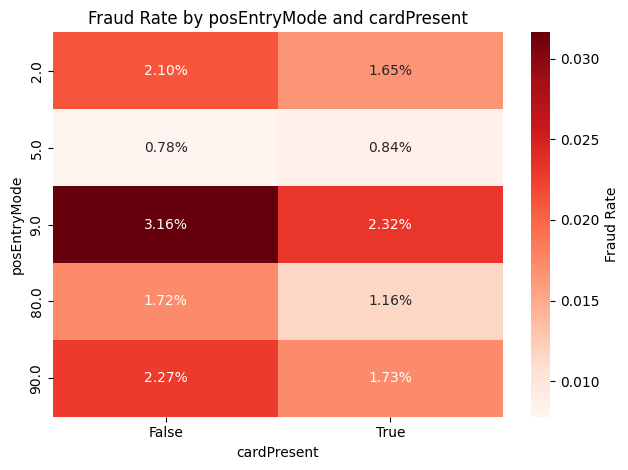

In [40]:
sns.heatmap(pivoting, annot=True,fmt=".2%", cmap="Reds",cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by posEntryMode and cardPresent') 
plt.ylabel('posEntryMode')
plt.xlabel('cardPresent')
plt.tight_layout()
save_fig("Fraud_Rate_by_posEntryMode_and_cardPresent")
plt.show()

* The combination of 9.0 posEntryMode and absent of card is more prone to fraud comparatively followed by combination (9, Presence of card)
* Overall posEntryMode encoded as 9.0 is more prone to fraud.

In [6]:
df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day'],
      dtype='object')

## Do certain customers get frauded more on specific merchants?


In [9]:
grouped =  transaction_df.groupby(["customerId","merchantBrand"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["total_transactions"])
grouped.sort_values(by=["total_transactions","fraud_transaction"],ascending=False).head(10)

,customerId,merchantBrand,total_transactions,fraud_transaction,fraud_rate
76967,838085703,AMC,1904,30,0.015756
76989,838085703,EZ Putt Putt,1504,15,0.009973
13304,239875038,Rodeway Inn,1106,5,0.004521
12827,235721673,AMC,1006,4,0.003976
11599,226896970,AMC,919,13,0.014146
13289,239875038,Hilton Hotels,831,13,0.015644
12840,235721673,EZ Putt Putt,830,13,0.015663
21904,318001076,gap.com,811,5,0.006165
21907,318001076,sears.com,798,0,0.000000
21909,318001076,target.com,788,108,0.137056


In [20]:
top_10 = grouped.sort_values(by=["fraud_transaction"],ascending=False).head(10)

In [23]:
top_10

,customerId,merchantBrand,total_transactions,fraud_transaction,fraud_rate
21163,311710839,Hyatt House,289,289,1.000000
25874,353215513,34th BBQ,171,171,1.000000
21909,318001076,target.com,788,108,0.137056
75276,822203001,Fast Repair,82,82,1.000000
14758,251625315,KFC,65,65,1.000000
8745,200778999,Regal Cinemas,64,64,1.000000
14757,251625315,In-N-Out,59,59,1.000000
87635,938310147,Lyft,59,59,1.000000
28519,378029122,West End Beauty,58,58,1.000000
63757,717128593,Dinosaur Sandwitch Bar,47,47,1.000000


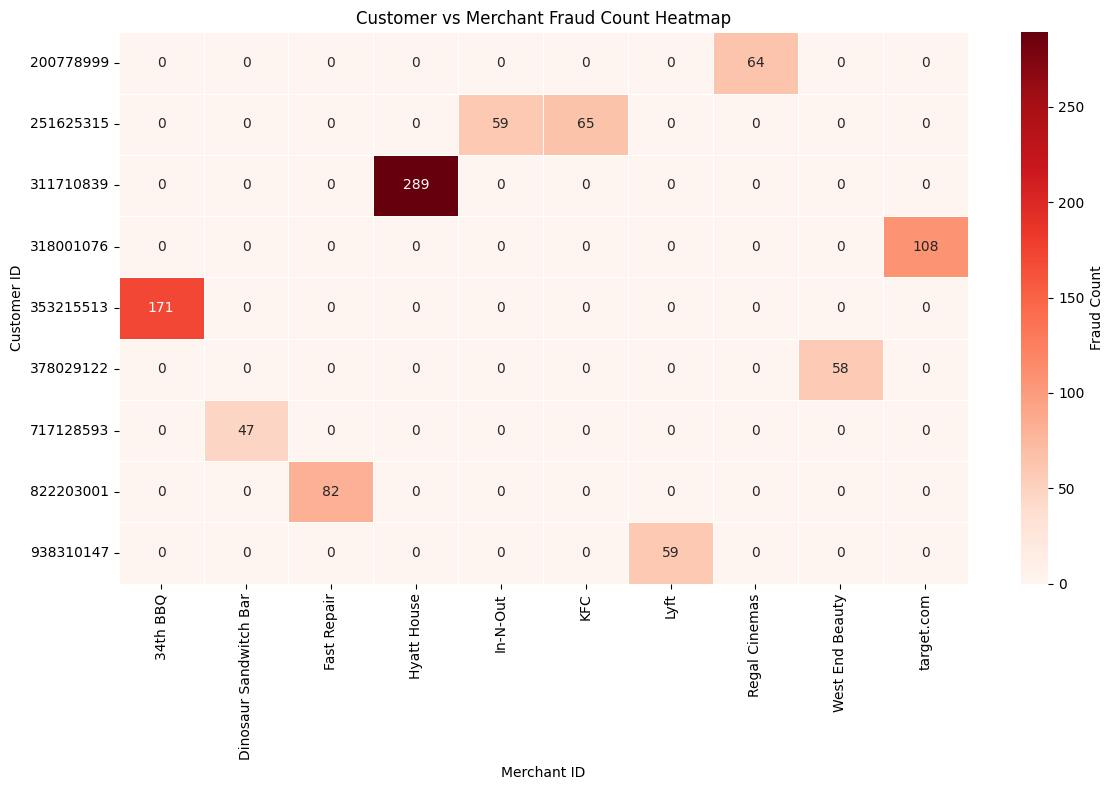

In [27]:
pivot = top_10.pivot(index='customerId', columns='merchantBrand', values='fraud_transaction').fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="Reds", linewidths=0.5, annot=True, fmt=".0f", cbar_kws={'label': 'Fraud Count'})
plt.title('Customer vs Merchant Fraud Count Heatmap')
plt.xlabel('Merchant ID')
plt.ylabel('Customer ID')
save_fig("Customer_vs_Merchant_Fraud_Count_Heatmap")
plt.show()


* 311710839 with Hyatt House merchant has almost all fraud transactions only(289).
* 353215513 with 34th BBQ also has all fraud transctions only (171).

In [26]:
transaction_df[(transaction_df["customerId"] == 311710839) & (transaction_df["merchantBrand"]== "Hyatt House")]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand
565628,311710839,311710839,7500,7500.00,2016-01-01 08:02:07,32.69,Hyatt House #524654,US,US,9.0,...,PURCHASE,True,0.00,True,False,0,8,1,1,Hyatt House
565633,311710839,311710839,7500,6776.31,2016-01-01 23:10:49,67.33,Hyatt House #862059,US,US,9.0,...,PURCHASE,True,723.69,False,False,0,23,1,1,Hyatt House
565648,311710839,311710839,7500,5515.17,2016-01-05 02:58:04,136.78,Hyatt House #161001,US,US,2.0,...,PURCHASE,True,1984.83,False,False,0,2,1,5,Hyatt House
565654,311710839,311710839,7500,4584.64,2016-01-06 12:36:42,43.93,Hyatt House #461673,US,US,9.0,...,PURCHASE,True,2915.36,True,False,0,12,1,6,Hyatt House
565668,311710839,311710839,7500,2731.28,2016-01-08 07:47:32,7.01,Hyatt House #551924,US,US,5.0,...,PURCHASE,True,4768.72,True,False,0,7,1,8,Hyatt House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567422,311710839,311710839,7500,5903.91,2016-12-24 22:31:00,31.21,Hyatt House #469765,US,US,9.0,...,PURCHASE,True,1596.09,False,False,0,22,12,24,Hyatt House
567430,311710839,311710839,7500,5506.61,2016-12-27 07:50:20,59.22,Hyatt House #524654,US,US,2.0,...,PURCHASE,True,1993.39,True,False,0,7,12,27,Hyatt House
567431,311710839,311710839,7500,5447.39,2016-12-27 18:12:17,157.88,Hyatt House #998451,US,US,90.0,...,PURCHASE,True,2052.61,True,False,0,18,12,27,Hyatt House
567435,311710839,311710839,7500,4909.97,2016-12-28 15:40:17,311.50,Hyatt House #972825,US,US,5.0,...,PURCHASE,True,2590.03,True,False,0,15,12,28,Hyatt House


##  Is there a pattern between customer balance and transaction type in fraud cases?

In [30]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]

In [31]:
fraud_df.groupby(["transactionType"])["currentBalance"].describe()

,count,mean,std,min,25%,50%,75%,max
transactionType,,,,,,,,
ADDRESS_VERIFICATION,87.0,3853.208966,3640.026933,0.0,1134.030,3124.710,5718.5000,16851.82
PURCHASE,10581.0,4410.072962,6214.727730,0.0,687.170,2512.440,5607.7900,47383.32
REVERSAL,288.0,4986.740868,6686.269245,0.0,955.965,3189.285,6549.1025,46229.26


In [33]:
fraud_df["currentBalance"].describe()

count    10956.000000
mean      4420.809836
std       6211.848815
min          0.000000
25%        697.097500
50%       2534.000000
75%       5645.220000
max      47383.320000
Name: currentBalance, dtype: float64

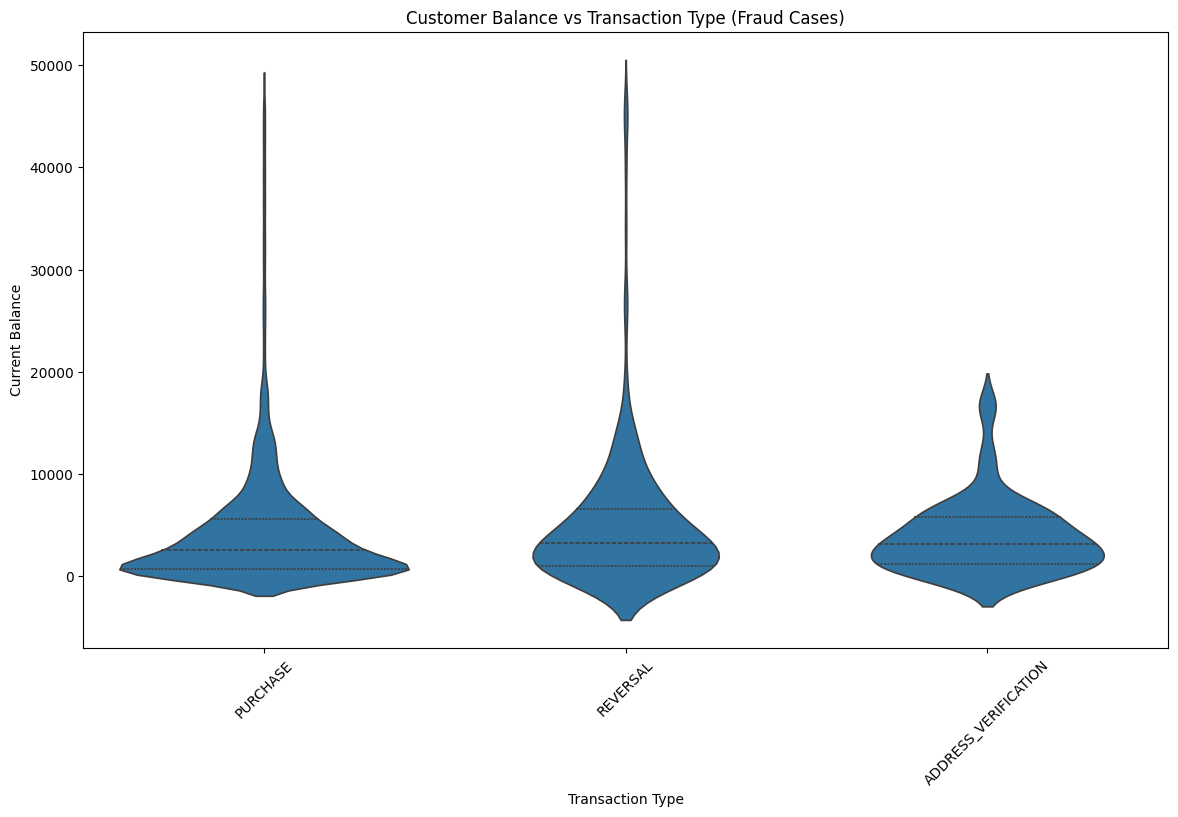

In [34]:
plt.figure(figsize=(14, 8))
sns.violinplot(x='transactionType', y='currentBalance', data=fraud_df, inner='quartile')
plt.title('Customer Balance vs Transaction Type (Fraud Cases)')
plt.xticks(rotation=45)
plt.xlabel('Transaction Type')
plt.ylabel('Current Balance')
plt.show()


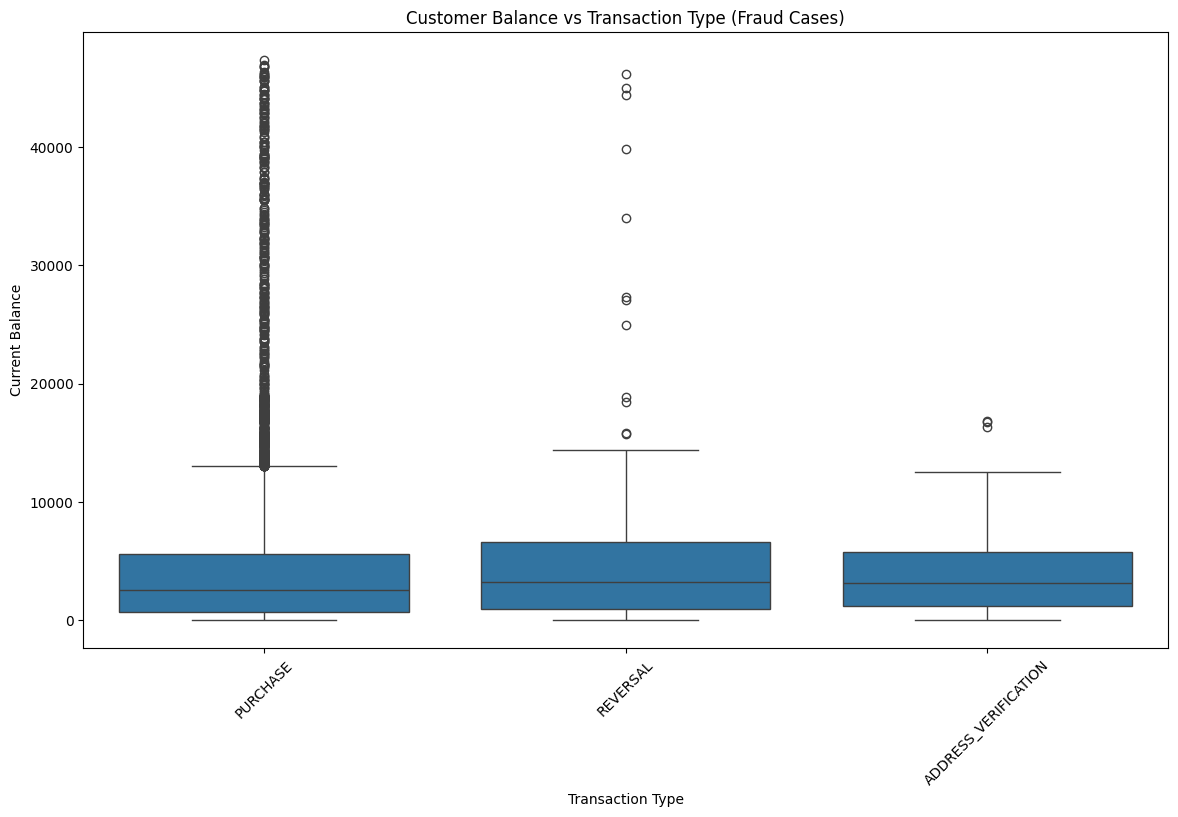

In [35]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='transactionType', y='currentBalance', data=fraud_df)
plt.title('Customer Balance vs Transaction Type (Fraud Cases)')
plt.xticks(rotation=45)
plt.xlabel('Transaction Type')
plt.ylabel('Current Balance')
plt.show()


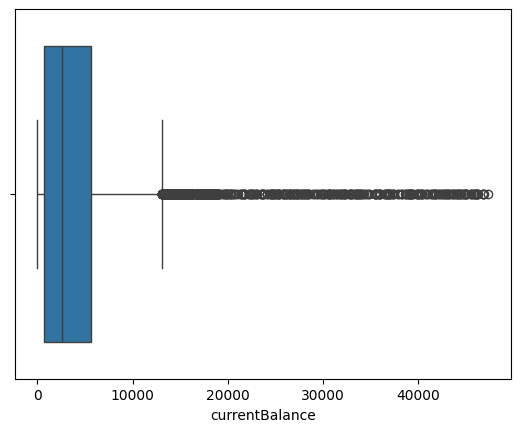

In [37]:
sns.boxplot(data=fraud_df, x="currentBalance")
plt.show()

<Axes: xlabel='currentBalance', ylabel='Count'>

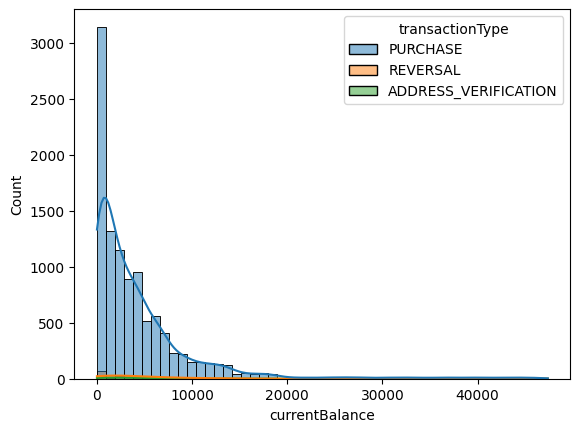

In [42]:
sns.histplot(data=fraud_df, x='currentBalance',hue="transactionType",bins=50, kde=True)

<Axes: xlabel='currentBalance', ylabel='transactionAmount'>

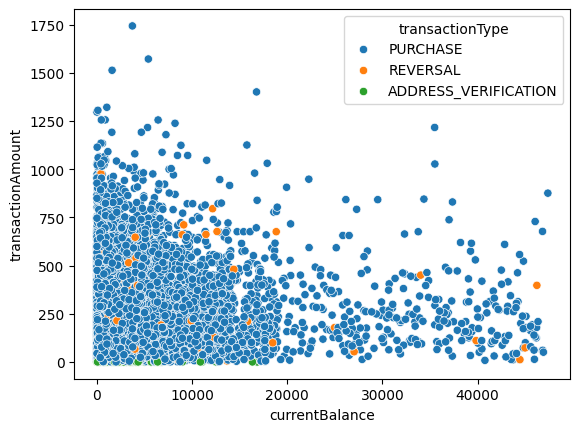

In [43]:
sns.scatterplot(data=fraud_df, x='currentBalance', y='transactionAmount', hue='transactionType')

In [44]:
transaction_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day', 'merchantBrand'],
      dtype='object')

## How date of last address change associate with fraud transactions?

In [53]:
transaction_df["dateOfLastAddressChange"] = pd.to_datetime(transaction_df["dateOfLastAddressChange"], dayfirst=True)

In [54]:
transaction_df["dateOfLastAddressChange"].iloc[:]

0        2014-08-03
1        2014-08-03
2        2014-08-03
3        2014-08-03
4        2014-08-03
            ...    
637661   2016-06-03
637662   2016-06-03
637663   2016-06-03
637664   2016-06-03
637665   2016-06-03
Name: dateOfLastAddressChange, Length: 637666, dtype: datetime64[ns]

In [ ]:
transaction_df["gap_addressChange_transaction"] = (transaction_df["transactionDateTime"] - transaction_df["dateOfLastAddressChange"]).dt.days

# recentAddressChange' if gap < 30 days
transaction_df["recentAddressChange"] = transaction_df["gap_addressChange_transaction"] < 30

In [57]:
transaction_df.groupby("isFraud")["gap_addressChange_transaction"].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,626710.0,535.060687,678.716635,0.0,59.0,266.0,783.0,11320.0
True,10956.0,485.095199,647.063353,0.0,51.0,204.0,674.0,5785.0


In [60]:
transaction_df["recentAddressChange"].value_counts()

recentAddressChange
False    533991
True     103675
Name: count, dtype: int64

In [58]:
transaction_df.groupby("isFraud")["recentAddressChange"].mean()

isFraud
False    0.162324
True     0.177528
Name: recentAddressChange, dtype: float64

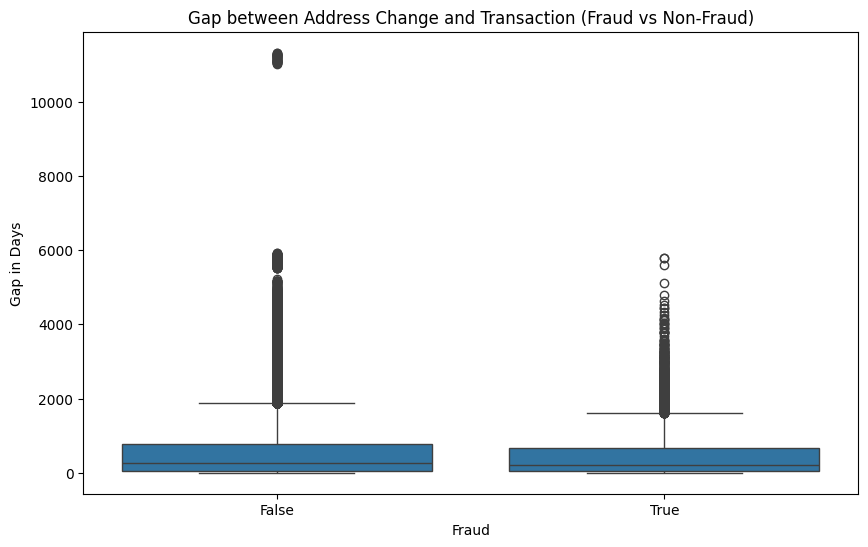

In [62]:
plt.figure(figsize=(10,6))
sns.boxplot(x="isFraud", y="gap_addressChange_transaction", data=transaction_df)
plt.title("Gap between Address Change and Transaction (Fraud vs Non-Fraud)")
plt.xlabel("Fraud")
plt.ylabel("Gap in Days")
plt.show()

* Outliers are present heavily in non-fraud cases (some customers didn’t update their address for many years — we can see extreme points up to ~11,000 days ≈ 30 years).

* Fraud cases have fewer extreme outliers — meaning fraudsters' addresses are more recently changed compared to random genuine users.

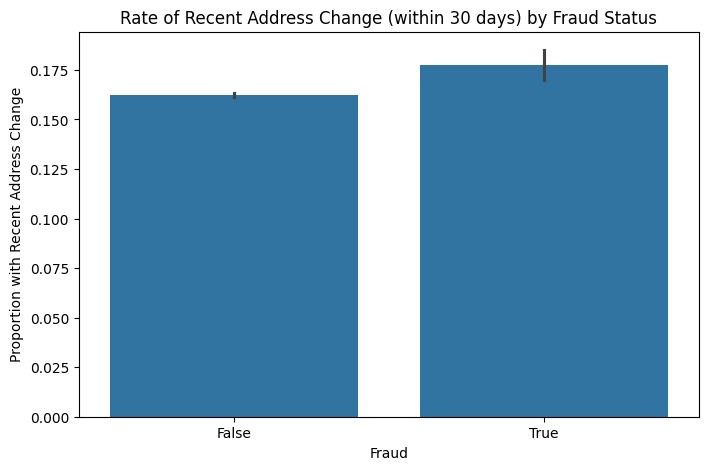

In [66]:
plt.figure(figsize=(8,5))
sns.barplot(x="isFraud", y="recentAddressChange", data=transaction_df)
plt.title("Rate of Recent Address Change (within 30 days) by Fraud Status")
plt.xlabel("Fraud")
plt.ylabel("Proportion with Recent Address Change")
plt.show()


* Fraudulent transactions (True) are more likely to have had a recent address change (within 30 days) compared to non-fraudulent transactions (False).
* The difference is visible, but not massive.

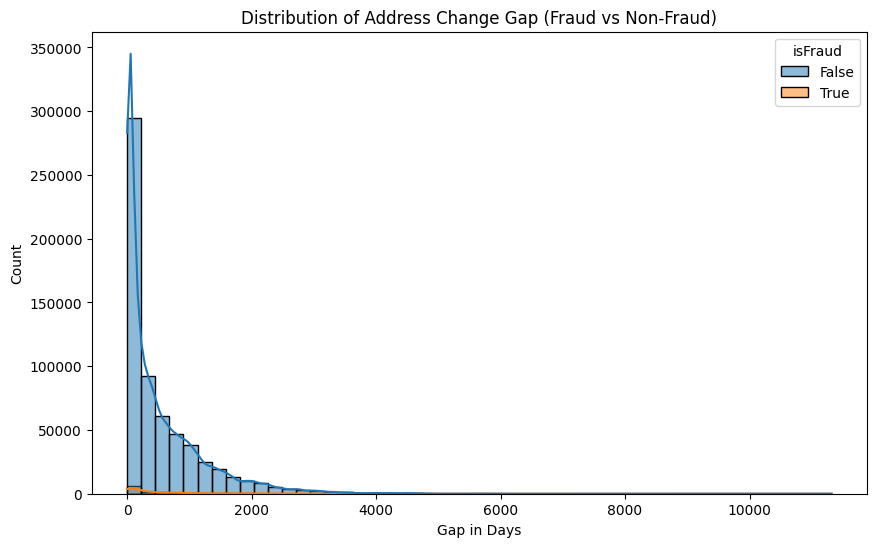

In [65]:
plt.figure(figsize=(10,6))
sns.histplot(data=transaction_df, x="gap_addressChange_transaction", hue="isFraud", bins=50, kde=True)
plt.title("Distribution of Address Change Gap (Fraud vs Non-Fraud)")
plt.xlabel("Gap in Days")
plt.ylabel("Count")
plt.show()

## What time of day or day of the week sees more fraud?

#### Month

In [3]:
transaction_df.groupby(["txn_month"])["accountNumber"].agg("count").reset_index()

,txn_month,accountNumber
0,1,49513
1,2,47624
2,3,51641
3,4,50487
4,5,53147
5,6,52294
6,7,54508
7,8,55202
8,9,53997
9,10,56976


In [ ]:
monthly_data = transaction_df.groupby('txn_month').agg(
    transaction_count = ('accountNumber','count'),
    fraud_count = ('isFraud','sum'),
    average_transaction_amount = ('transactionAmount','mean'),
    average_fraud_amount = ('transactionAmount',lambda x: x[transaction_df["isFraud"] == 1].mean()),
).reset_index()

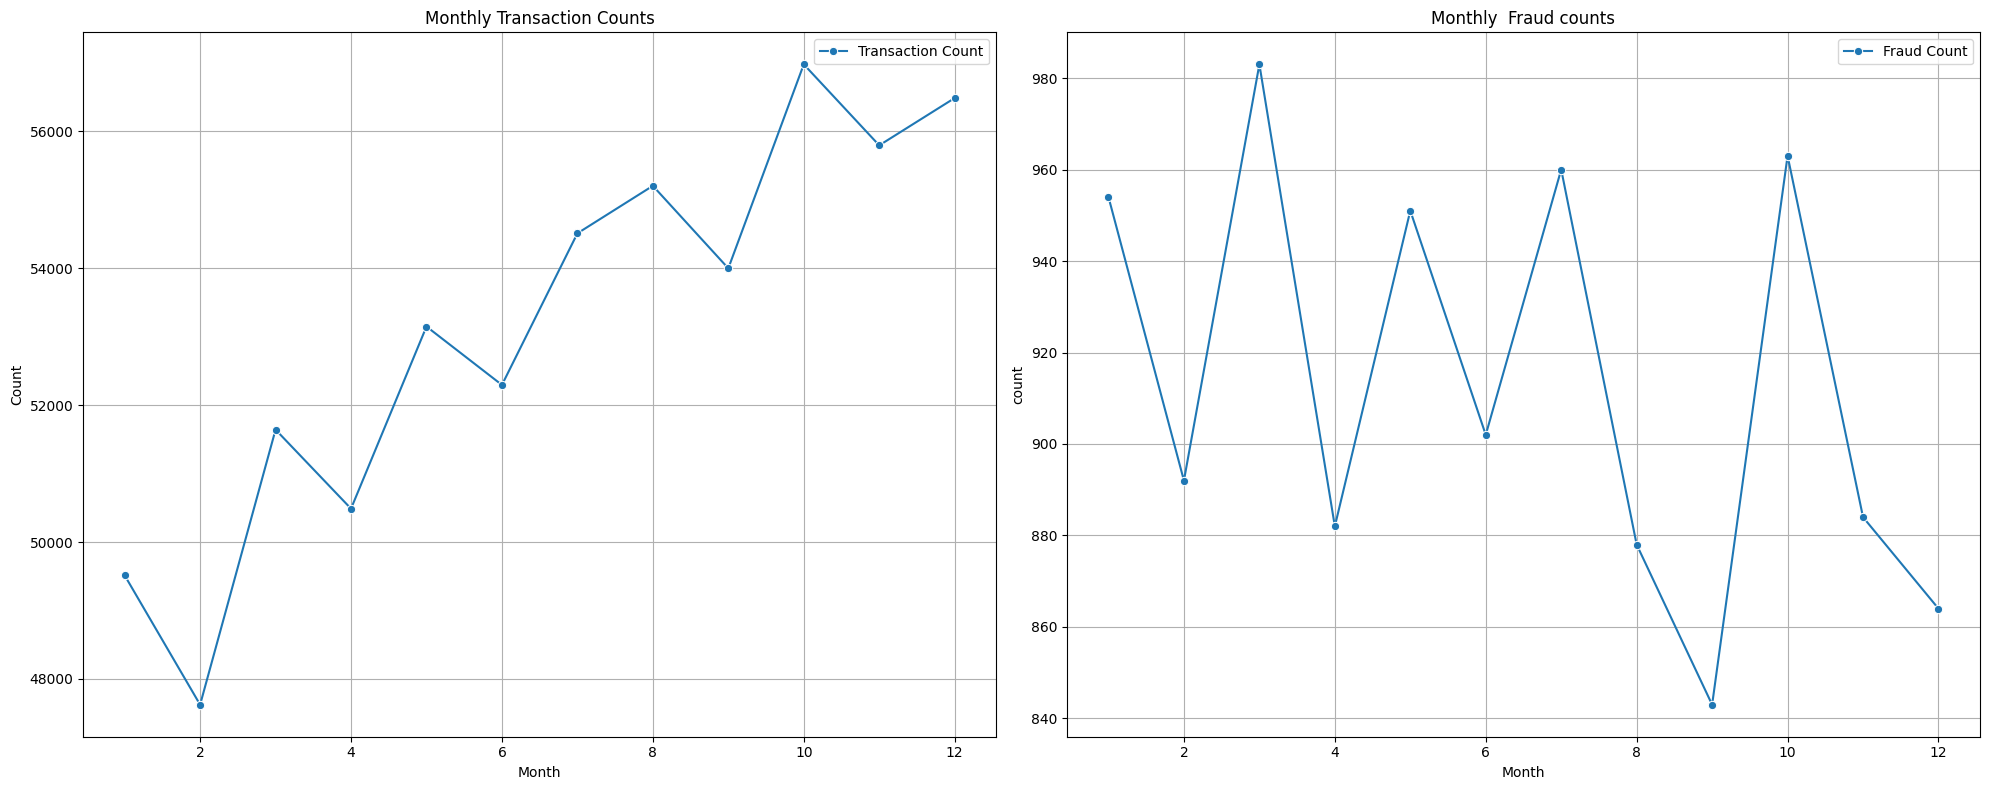

In [90]:
fig, axes = plt.subplots(1,2, figsize=(20, 8), sharex=True)

sns.lineplot(data=monthly_data, x='txn_month', y='transaction_count', ax=axes[0], marker='o')
axes[0].set_title('Monthly Transaction Counts')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Month')
axes[0].legend(["Transaction Count"])
axes[0].grid(True)



sns.lineplot(data=monthly_data, x='txn_month', y='fraud_count', ax=axes[1], marker='o')
axes[1].set_title('Monthly  Fraud counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel('Month')
axes[1].legend(["Fraud Count"])
axes[1].grid(True)
save_fig("Monthly_Transaction_and_Fraud_Counts")
plt.show()

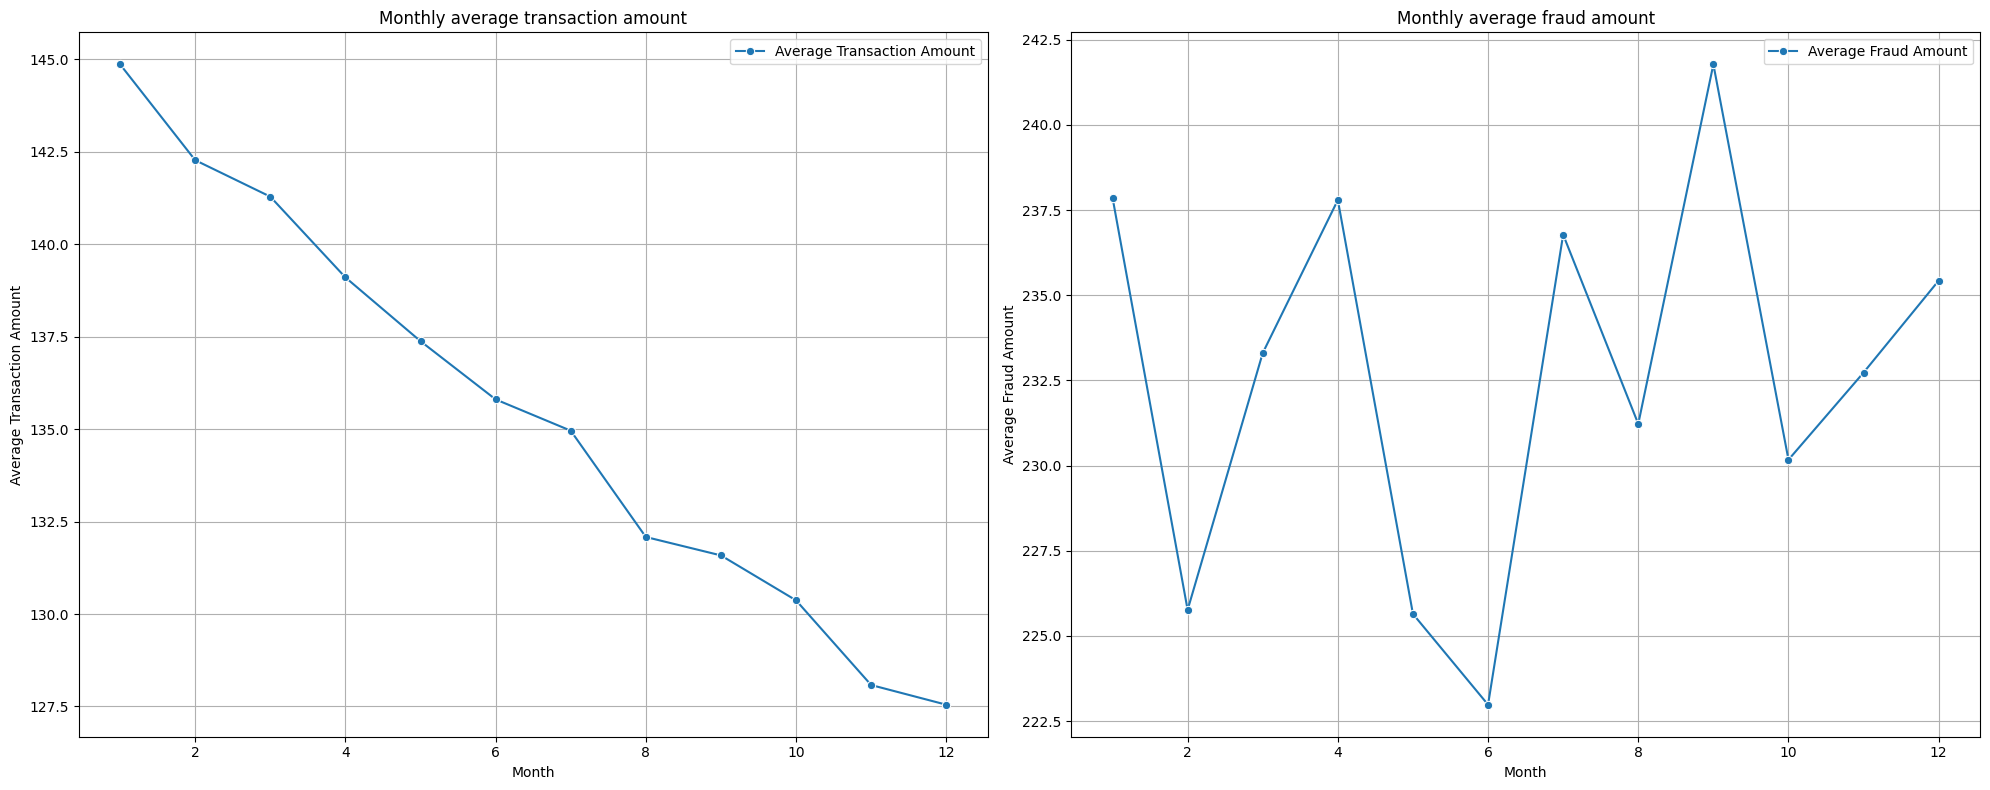

In [92]:
fig, axes = plt.subplots(1,2, figsize=(20, 8), sharex=True)

sns.lineplot(data=monthly_data, x='txn_month', y='average_transaction_amount', ax=axes[0], marker='o')
axes[0].set_title('Monthly average transaction amount')
axes[0].set_ylabel('Average Transaction Amount')
axes[0].set_xlabel('Month')
axes[0].legend(["Average Transaction Amount"])
axes[0].grid(True)



sns.lineplot(data=monthly_data, x='txn_month', y='average_fraud_amount', ax=axes[1], marker='o')
axes[1].set_title('Monthly average fraud amount')
axes[1].set_ylabel('Average Fraud Amount')
axes[1].set_xlabel('Month')
axes[1].legend(["Average Fraud Amount"])
axes[1].grid(True)
save_fig("Monthly_Average_Transaction_and_Fraud_Amounts")
plt.show()

In [93]:
(transaction_df[(transaction_df["isFraud"] == 1) & (transaction_df["txn_month"]==1)]["transactionAmount"].sum())/(transaction_df[(transaction_df["isFraud"] == 1) & (transaction_df["txn_month"]==1)]["transactionAmount"].count())

np.float64(237.86504192872118)

* The dataset is of one year (2016) Jan to Dec.
* Febraury has lowest transaction amount and October has highest transaction amount and same about number of transaction.
* But surprisingly, the average amount of transaction is decreased throughout the year, whereas Number of transactions are fluctuating.
* Number of fraud transacations are distributed equally for each month, and March had highest number whereas september has lowest.

#### Hour

In [95]:
hourly_data = df.groupby('txn_hour').agg(
    transaction_count = ('accountNumber','count'),
    fraud_count = ('isFraud','sum'),
    average_transaction_amount = ('transactionAmount','mean'),
    average_fraud_amount = ('transactionAmount',lambda x: x[transaction_df["isFraud"] == 1].mean()),
).reset_index()

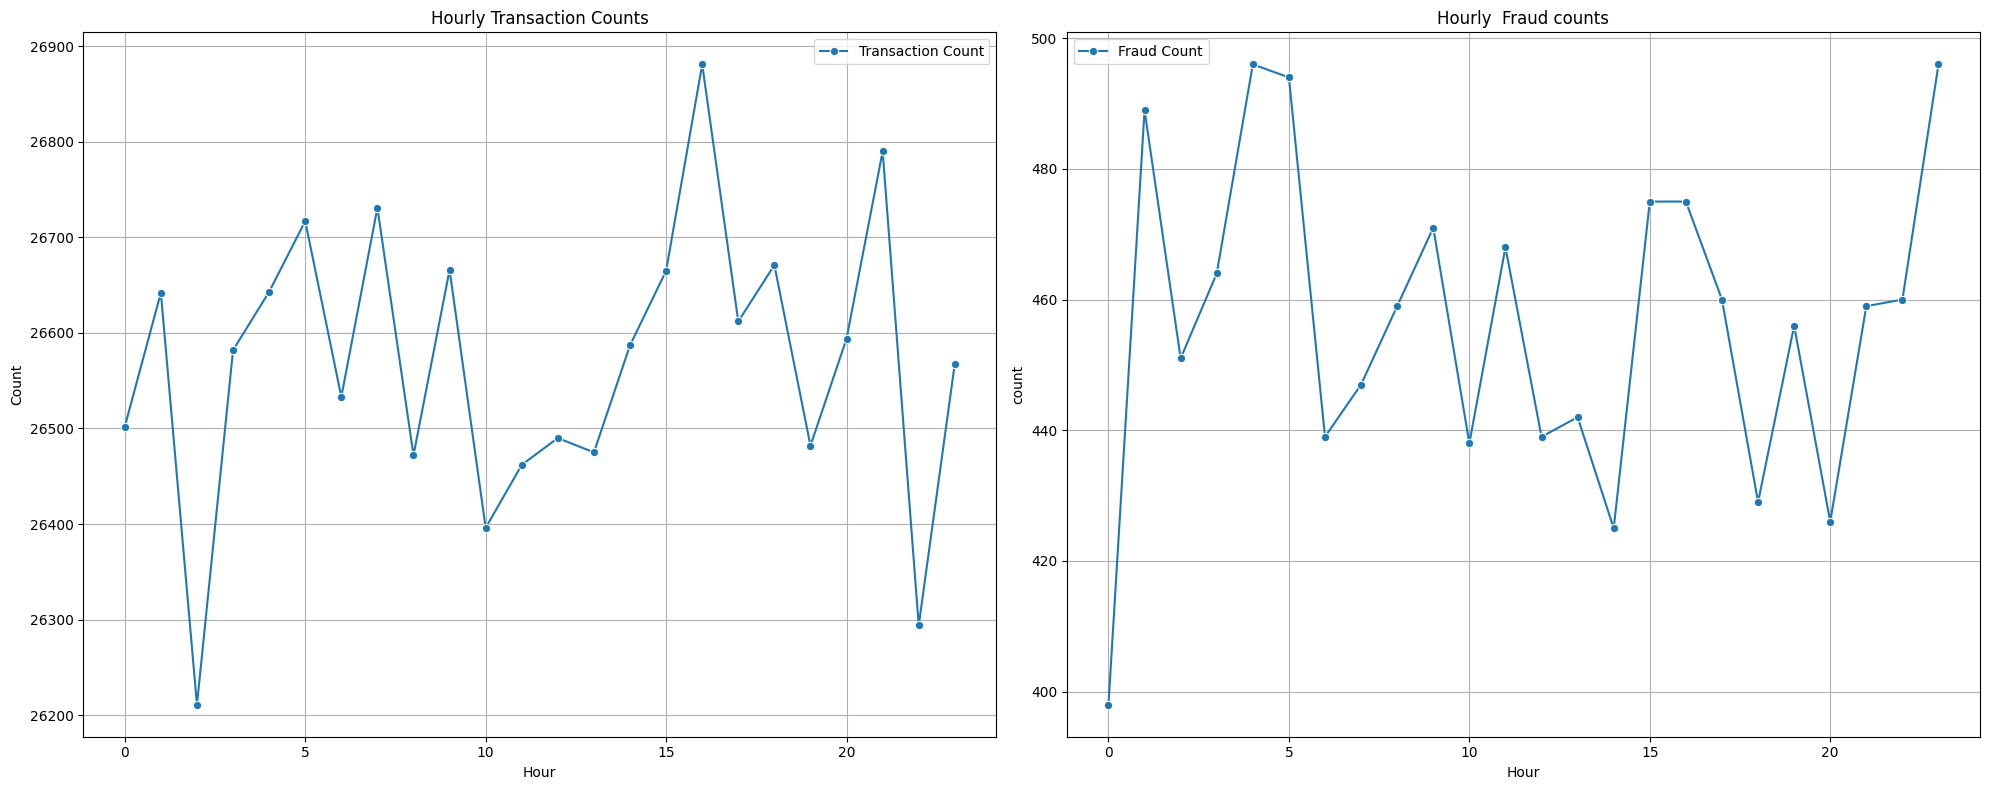

In [96]:
fig, axes = plt.subplots(1,2, figsize=(20, 8), sharex=True)

sns.lineplot(data=hourly_data, x='txn_hour', y='transaction_count', ax=axes[0], marker='o')
axes[0].set_title('Hourly Transaction Counts')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Hour')
axes[0].legend(["Transaction Count"])
axes[0].grid(True)



sns.lineplot(data=hourly_data, x='txn_hour', y='fraud_count', ax=axes[1], marker='o')
axes[1].set_title('Hourly  Fraud counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel('Hour')
axes[1].legend(["Fraud Count"])
axes[1].grid(True)
save_fig("Hourly_Transaction_and_Fraud_Counts")
plt.show()

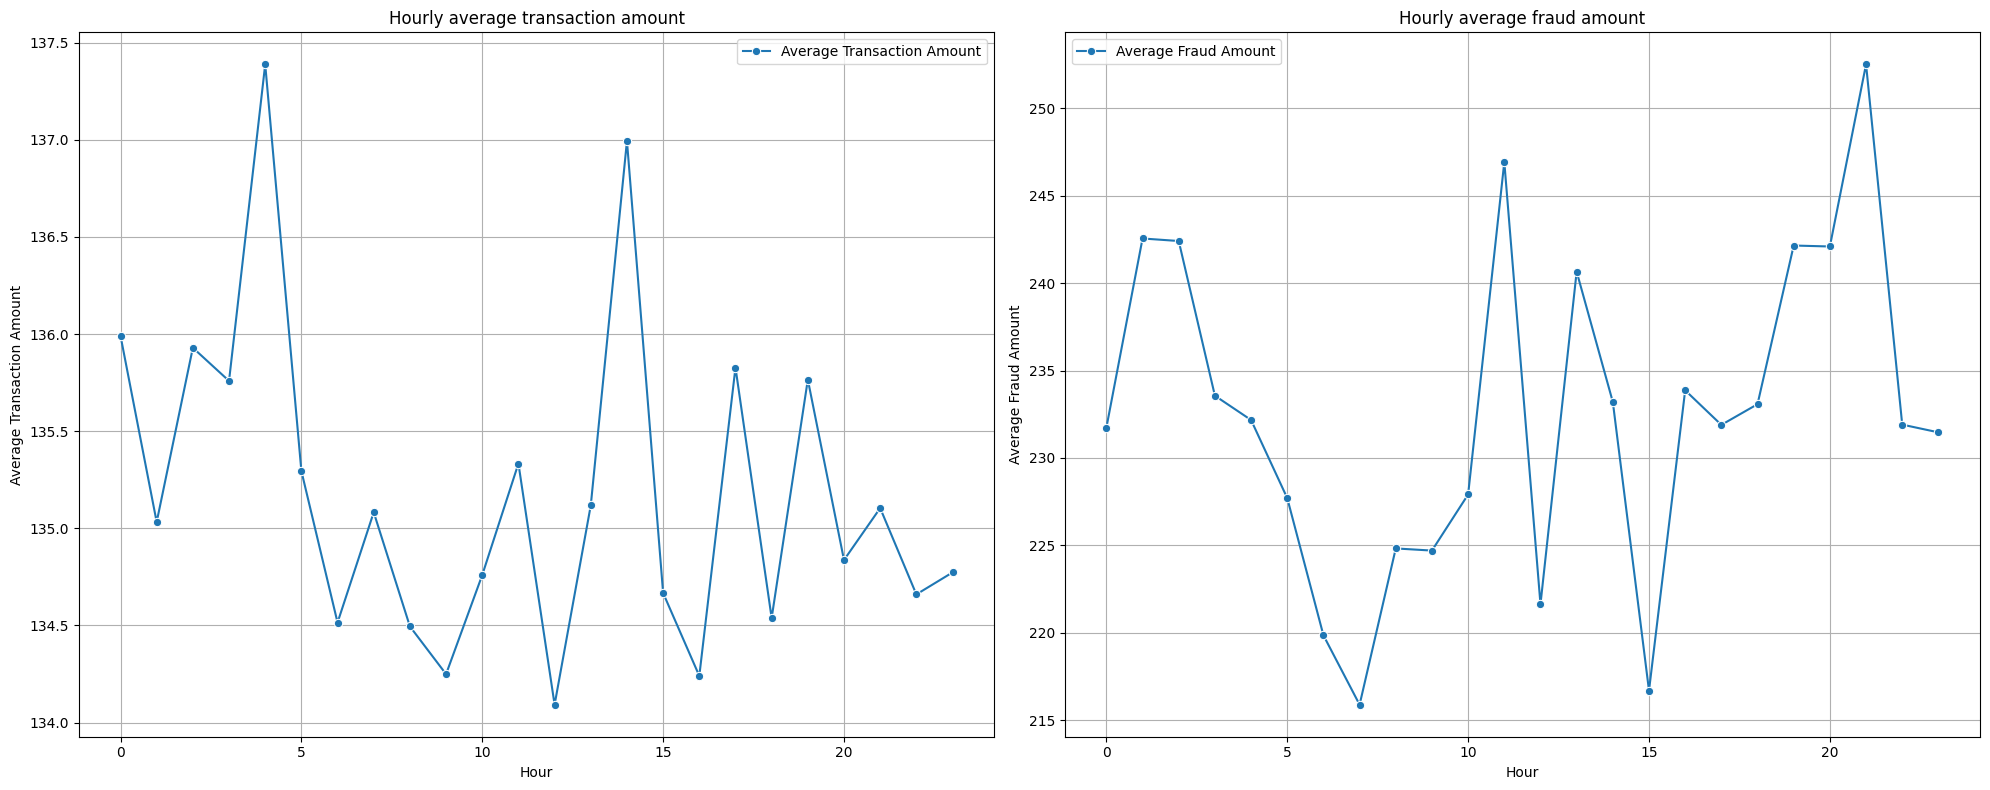

In [98]:
fig, axes = plt.subplots(1,2, figsize=(20, 8), sharex=True)

sns.lineplot(data=hourly_data, x='txn_hour', y='average_transaction_amount', ax=axes[0], marker='o')
axes[0].set_title('Hourly average transaction amount')
axes[0].set_ylabel('Average Transaction Amount')
axes[0].set_xlabel('Hour')
axes[0].legend(["Average Transaction Amount"])
axes[0].grid(True)



sns.lineplot(data=hourly_data, x='txn_hour', y='average_fraud_amount', ax=axes[1], marker='o')
axes[1].set_title('Hourly average fraud amount')
axes[1].set_ylabel('Average Fraud Amount')
axes[1].set_xlabel('Hour')
axes[1].legend(["Average Fraud Amount"])
axes[1].grid(True)
save_fig("Hourly_Average_Transaction_and_Fraud_Amounts")
plt.show()

* Number of transaction is highest at 4 PM evening whereas lowest at 2 AM (morning)
* Average amount of transaction is higher at 4 AM (morning) where as lowest at 12 PM (Noon)
* The count of fraud transaction is between 400 to 500 per hour.
* More fraud transactions take place around 11 pm, 4 am and 5 am whereas there are low fraud transactions around 12 Am.(Comparatively)

#### Day of week

In [6]:
transaction_df["txn_day"] = transaction_df["transactionDateTime"].dt.day_name()

In [114]:
transaction_df[transaction_df["isFraud"] == 1]["txn_day"].value_counts().sort_index()

txn_day
Friday       1562
Monday       1559
Saturday     1580
Sunday       1593
Thursday     1532
Tuesday      1542
Wednesday    1588
Name: count, dtype: int64

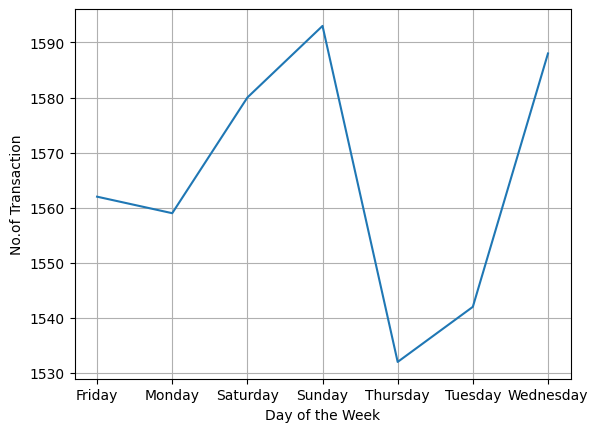

In [116]:
line_data_hour_isfraud = transaction_df[transaction_df["isFraud"] == 1].groupby(["txn_day"]).agg("count").reset_index()
sns.lineplot(line_data_hour_isfraud, x = "txn_day", y ="transactionAmount")
plt.ylabel("No.of Transaction")
plt.xlabel("Day of the Week")
plt.grid(True)
plt.show()

* Average of transaction amount is quite equal for each day, but comparatively Tuesday has highest value and Thursday has lowest.
* Number of transaction are between the range (90000 to 93000), and Friday has highest number of transaction in that year whereas saturday has lowest.
* In fraud case, each day has fraud transactions between 1530 to 1590,
 and sunday has highest whereas Thurday has lowest.

#### What time of each day of week?

In [11]:
fraud_per_day_per_hour = transaction_df.groupby(["txn_day","txn_hour"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()

In [23]:
fraud_per_day_per_hour["fraud_rate"]= round((fraud_per_day_per_hour["fraud_transaction"] / fraud_per_day_per_hour["total_transactions"])* 100,4)

In [40]:
fraud_per_day_per_hour.groupby("txn_day")["fraud_transaction"].sum().sort_values(ascending=False)

txn_day
Sunday       1593
Wednesday    1588
Saturday     1580
Friday       1562
Monday       1559
Tuesday      1542
Thursday     1532
Name: fraud_transaction, dtype: int64

In [30]:
highest_fraud_rate = []
highest_fraud_transactions = []

for day in fraud_per_day_per_hour['txn_day'].unique():
    day_df = fraud_per_day_per_hour[fraud_per_day_per_hour['txn_day'] == day]

    # Find row with max fraud_rate
    max_fraud_rate_row = day_df.loc[day_df['fraud_rate'].idxmax()]
    highest_fraud_rate.append({
        'txn_day': day,
        'txn_hour_highest_fraud_rate': int(max_fraud_rate_row['txn_hour']),
        'fraud_rate': max_fraud_rate_row['fraud_rate']
    })

    # Find row with max fraud_transactions
    max_fraud_txn_row = day_df.loc[day_df['fraud_transaction'].idxmax()]
    highest_fraud_transactions.append({
        'txn_day': day,
        'txn_hour_highest_fraud_transaction': int(max_fraud_txn_row['txn_hour']),
        'fraud_transaction': int(max_fraud_txn_row['fraud_transaction'])
    })

fraud_rate_df = pd.DataFrame(highest_fraud_rate)
fraud_transactions_df = pd.DataFrame(highest_fraud_transactions)

result = pd.merge(fraud_rate_df, fraud_transactions_df, on='txn_day')


In [29]:
result

,txn_day,txn_hour_highest_fraud_rate,fraud_rate,txn_hour_highest_fraud_transaction,fraud_transaction
0,Friday,15,2.0186,15,78
1,Monday,4,2.2715,4,87
2,Saturday,22,2.3842,22,88
3,Sunday,2,1.9603,16,74
4,Thursday,19,2.3103,19,88
5,Tuesday,4,2.1199,4,81
6,Wednesday,11,2.2825,11,85


## does card last digit having length less than 4 are more prone to fraud(cardLast4Digits)?

In [7]:
transaction_df["cardLast4Digits"].value_counts()

cardLast4Digits
1789    9977
5658    8369
0       6697
5335    5509
4062    5115
        ... 
9606       1
9071       1
2335       1
6945       1
2203       1
Name: count, Length: 5134, dtype: int64

In [9]:
def check_card_number(card_number):
    card_number = str(card_number)
    if len(card_number) == 4 and card_number.isdigit():
        return True
    else:
        return False
transaction_df["valid_cardLast4Digits"] = transaction_df["cardLast4Digits"].apply(check_card_number)
transaction_df["valid_cardLast4Digits"].value_counts()

valid_cardLast4Digits
True     571959
False     65707
Name: count, dtype: int64

In [12]:
transaction_df[transaction_df["valid_cardLast4Digits"] == 0]["cardLast4Digits"]

461       558
462       558
463       558
464       558
465       558
         ... 
637418      0
637610    965
637611    965
637612    965
637613    965
Name: cardLast4Digits, Length: 65707, dtype: int64

In [15]:
fraud_invalid_card = transaction_df[transaction_df["isFraud"] == 1]["valid_cardLast4Digits"].reset_index()

In [32]:
grouped = transaction_df.groupby(["valid_cardLast4Digits"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum"
).reset_index()
grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["fraud_transaction"].sum())
grouped.sort_values(by=["total_transactions","fraud_transaction"],ascending=False)

,valid_cardLast4Digits,total_transactions,fraud_transaction,fraud_rate
1,True,571959,9819,0.896221
0,False,65707,1137,0.103779


* Around 90% of fraud transactions are done by customer having 4 digit card Number.
* valid_cardLast4Digits can be good feature to determine fradulant transactions. 

##  Are identical transactionAmount + merchantName + accountNumber pairs within 1 hour likely fraud?

In [37]:
transaction_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day', 'valid_cardLast4Digits'],
      dtype='object')

In [ ]:
transaction_df[["transactionAmount","merchantName","accountNumber"]].duplicated().sum()

np.int64(64198)

In [65]:
grouped = transaction_df[transaction_df["isFraud"] == 1].groupby(["accountNumber","merchantBrand","transactionAmount"]).agg(
        total_transactions = ('isFraud','count'),
        fraud_transaction = ('isFraud','sum')
    ).reset_index()

grouped["fraud_rate"] = (grouped["fraud_transaction"] / grouped["total_transactions"])
grouped

,accountNumber,merchantBrand,transactionAmount,total_transactions,fraud_transaction,fraud_rate
0,100547107,Tim Hortons,286.07,1,1,1.0
1,101680180,ebay.com,190.49,1,1,1.0
2,101680180,walmart.com,311.71,1,1,1.0
3,102307135,Universe Massage,64.92,1,1,1.0
4,102635965,Regal Cinemas,209.02,1,1,1.0
...,...,...,...,...,...,...
10528,998837644,walmart.com,314.97,1,1,1.0
10529,999275549,amazon.com,89.14,2,2,1.0
10530,999275549,discount.com,90.51,1,1,1.0
10531,999275549,oldnavy.com,227.96,1,1,1.0


<Axes: ylabel='Frequency'>

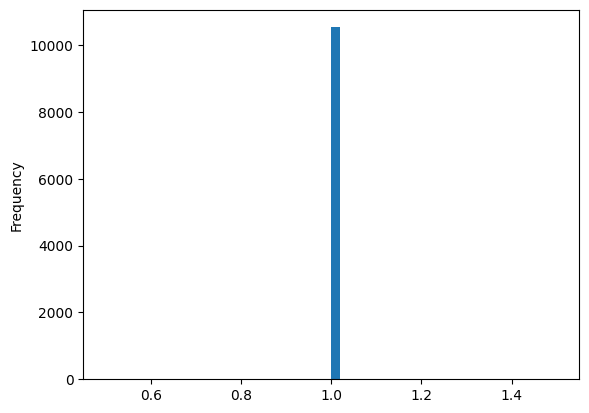

In [67]:
grouped["fraud_rate"].plot(kind="hist", bins=50)

In [68]:
transaction_new_df = transaction_df.sort_values(by=["accountNumber","merchantName","transactionAmount","transactionDateTime"])

In [69]:
transaction_new_df["prev_transaction_time"] = transaction_new_df.groupby(['accountNumber', 'merchantName', 'transactionAmount'])['transactionDateTime'].shift(1)

In [70]:
transaction_new_df["prev_transaction_time"]

579665                   NaT
579671   2016-05-29 19:23:34
579680   2016-06-29 19:48:39
579689   2016-07-30 07:33:20
579696   2016-08-31 04:55:03
                 ...        
169828                   NaT
169871                   NaT
169868                   NaT
169901                   NaT
169830                   NaT
Name: prev_transaction_time, Length: 637666, dtype: datetime64[ns]

In [71]:
transaction_new_df['time_diff_min'] = (transaction_new_df['transactionDateTime'] - transaction_new_df['prev_transaction_time']).dt.total_seconds() / 60


transaction_new_df['within_1hr'] = transaction_new_df['time_diff_min'] <= 60

fraud_within_1hr = transaction_new_df[transaction_new_df['within_1hr'] == True]['isFraud'].mean()
fraud_outside_1hr = transaction_new_df[transaction_new_df['within_1hr'] == False]['isFraud'].mean()

print(f"Fraud rate within 1 hour: {fraud_within_1hr:.4f}")
print(f"Fraud rate outside 1 hour: {fraud_outside_1hr:.4f}")

Fraud rate within 1 hour: 0.0207
Fraud rate outside 1 hour: 0.0171


## Does a high ratio of currentBalance/creditLimit correlate with fraud likelihood?

In [7]:
transaction_df["ratio_currbal_creditlimit"] = transaction_df["currentBalance"] / transaction_df["creditLimit"]
transaction_df["ratio_currbal_creditlimit"].describe()

count    637666.000000
mean          0.430047
std           0.312189
min           0.000000
25%           0.130706
50%           0.422739
75%           0.703735
max           5.111840
Name: ratio_currbal_creditlimit, dtype: float64

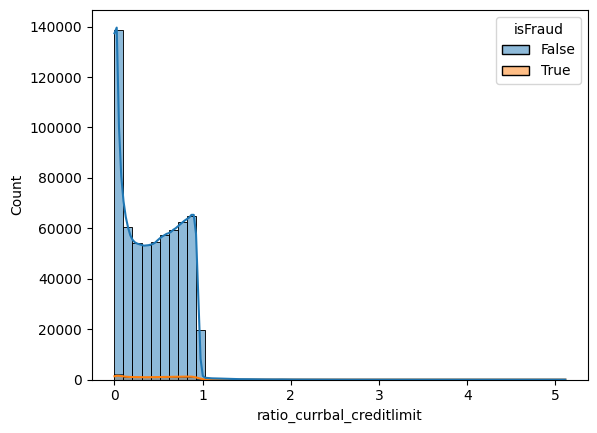

In [77]:
sns.histplot(data=transaction_df, x='ratio_currbal_creditlimit', hue="isFraud", bins=50, kde=True)
plt.show()

In [78]:
fraud_ratio = transaction_df[transaction_df["isFraud"] == 1]["ratio_currbal_creditlimit"]
non_fraud_ratio = transaction_df[transaction_df["isFraud"] == 0]["ratio_currbal_creditlimit"]

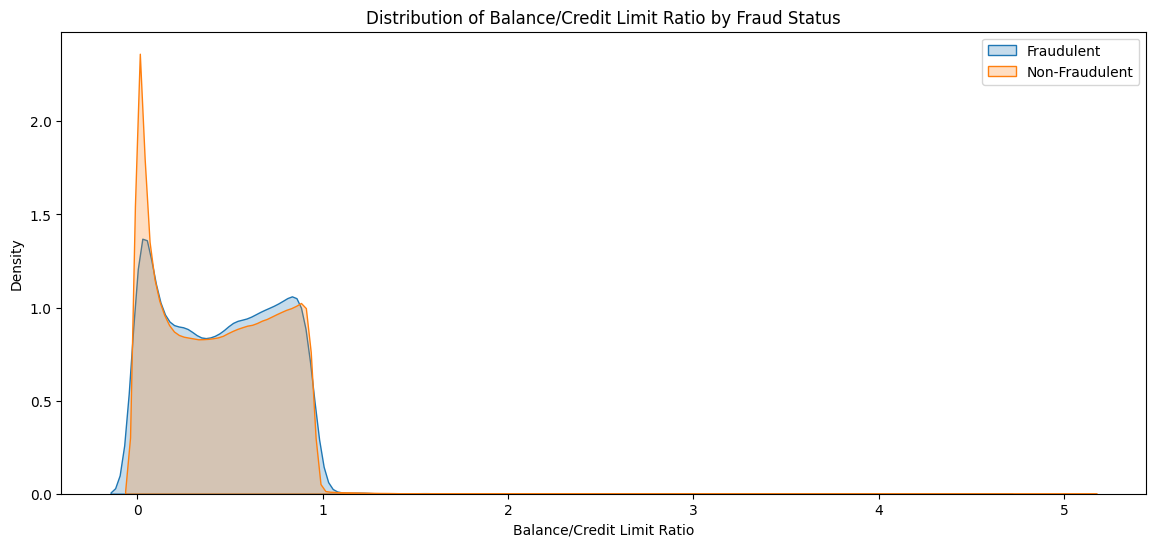

In [82]:
plt.figure(figsize=(14,6))

sns.kdeplot(fraud_ratio.dropna(), label='Fraudulent', fill=True)
sns.kdeplot(non_fraud_ratio.dropna(), label='Non-Fraudulent', fill=True)

plt.title('Distribution of Balance/Credit Limit Ratio by Fraud Status')
plt.xlabel('Balance/Credit Limit Ratio')
plt.ylabel('Density')
plt.legend() 
plt.show()

In [81]:
fraud_ratio.describe()

count    10956.000000
mean         0.448418
std          0.307241
min          0.000000
25%          0.161876
50%          0.451837
75%          0.717646
max          4.578560
Name: ratio_currbal_creditlimit, dtype: float64

In [83]:
non_fraud_ratio.describe()

count    626710.000000
mean          0.429726
std           0.312265
min           0.000000
25%           0.130142
50%           0.422220
75%           0.703474
max           5.111840
Name: ratio_currbal_creditlimit, dtype: float64

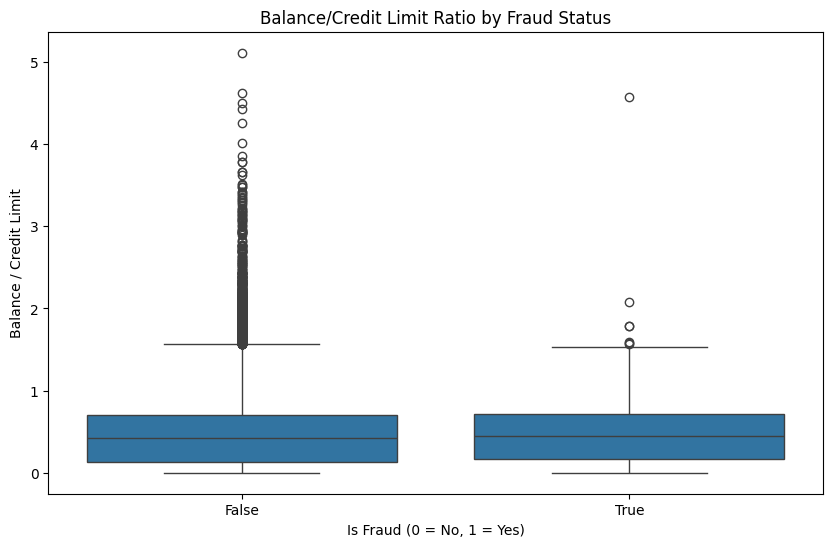

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='ratio_currbal_creditlimit', data=transaction_df)
plt.title('Balance/Credit Limit Ratio by Fraud Status')
plt.xlabel('Is Fraud (0 = No, 1 = Yes)')
plt.ylabel('Balance / Credit Limit')
plt.show()

In [14]:
(transaction_df[transaction_df["isFraud"] == 1]["ratio_currbal_creditlimit"] > 2).sum()

np.int64(2)

In [84]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(fraud_ratio.dropna(), non_fraud_ratio.dropna(), alternative='two-sided')
print(f"Mann-Whitney U Test statistic = {stat}, p-value = {p_value}")
alpha = 0.05
if p_value < alpha:
    print("Result: Significant difference between fraud and non-fraud balance/credit limit ratio distributions (reject H0)")
else:
    print("Result: No significant difference between fraud and non-fraud balance/credit limit ratio distributions (fail to reject H0)")

Mann-Whitney U Test statistic = 3562633846.5, p-value = 1.1938880428130968e-11
Result: Significant difference between fraud and non-fraud balance/credit limit ratio distributions (reject H0)


* We can consider the ratio between currentBalance and creditLimit be good variable to distingush fraud and non-fraud transactions.
* we can consider all transactions having ratio greater than 2 as non-fraud transactions. i.e only 2 transactions are fraud having ratio greater than 2.

## Do customers with multiple cardLast4Digits linked to the same account show different fraud rates?

In [5]:
transaction_df[["customerId","accountNumber","cardLast4Digits"]].duplicated().value_counts()

True     630398
False      7268
Name: count, dtype: int64

In [15]:
transaction_df.groupby(["customerId"])["accountNumber"].count()

customerId
100547107     84
100634414     24
100973869     45
101192712     20
101548993     29
            ... 
999273501      8
999275549    230
999789077     71
999984515     32
999985343    103
Name: accountNumber, Length: 5000, dtype: int64

In [23]:
transaction_df[transaction_df["customerId"] == 999275549]["accountNumber"].value_counts()

accountNumber
999275549    230
Name: count, dtype: int64

In [24]:
def count(row):
    if row["customerId"] == row["accountNumber"]:
        return 1
    else:
        return 0
transaction_df["customerId_accountNumber"] = transaction_df.apply(count, axis=1)
transaction_df["customerId_accountNumber"].value_counts()

customerId_accountNumber
1    637666
Name: count, dtype: int64

* It is clear that no customer has different account number used for transaction.

In [46]:
card_change = transaction_df[transaction_df["isFraud"] == 1].groupby(["customerId"])["cardLast4Digits"].nunique().reset_index()

In [49]:
card_change["cardLast4Digits"].value_counts()

cardLast4Digits
1    1871
2     349
3      43
4       4
Name: count, dtype: int64

In [50]:
card_change.columns = ['customerId', 'unique_card_counts']

In [51]:
same_card_users = (card_change['unique_card_counts'] == 1).sum()
different_card_users = (card_change['unique_card_counts'] > 1).sum()

In [52]:
same_card_users

np.int64(1871)

In [53]:
different_card_users

np.int64(396)

In [ ]:
card_change['card_status'] = card_change['unique_card_counts'].apply(lambda x: 'Same Card' if x == 1 else 'Changed Card')
transaction_with_card_info = transaction_df.merge(card_change[['customerId', 'card_status']], on='customerId', how='left')
fraud_analysis = transaction_with_card_info.groupby('card_status')['isFraud'].agg(['mean', 'count', 'sum']).reset_index()
fraud_analysis.rename(columns={'mean': 'fraud_rate', 'count': 'total_transactions', 'sum': 'fraudulent_transactions'}, inplace=True)
fraud_analysis

    card_status  fraud_rate  total_transactions  fraudulent_transactions
0  Changed Card    0.018259              229040                     4182
1     Same Card    0.016578              408626                     6774


## Are very small transactions (e.g., < $1) more likely to be fraudulent?

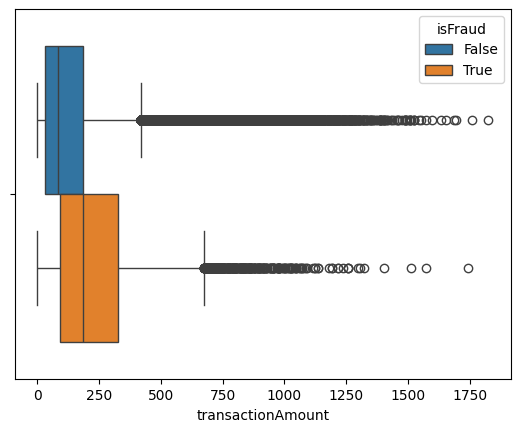

In [57]:
sns.boxplot(data=transaction_df, x="transactionAmount",hue="isFraud")
plt.show()

In [59]:
transaction_df['very_small_txn'] = transaction_df['transactionAmount'] < 1

small_txn_fraud_rate = transaction_df.groupby('very_small_txn')['isFraud'].agg(['mean', 'count', 'sum']).reset_index()
small_txn_fraud_rate.rename(columns={'mean': 'fraud_rate', 'count': 'total_transactions', 'sum': 'fraudulent_transactions'}, inplace=True)

print(small_txn_fraud_rate)

   very_small_txn  fraud_rate  total_transactions  fraudulent_transactions
0           False    0.017623              615512                    10847
1            True    0.004920               22154                      109


* Small transactions dont mean fraud transactions

## Are new customers (accountOpenDate < 7 days) with high transactionAmount (> 90th percentile) disproportionately targeted?

In [60]:
transaction_df["accountOpenDate"].dtype

dtype('<M8[ns]')

In [61]:
transaction_df['account_age_days'] = (transaction_df['transactionDateTime'] - transaction_df['accountOpenDate']).dt.days

In [69]:
transaction_90_percentile = transaction_df["transactionAmount"].quantile(0.9)

In [70]:
transaction_df['new_customer'] = transaction_df['account_age_days'] < 30
transaction_df['high_txn_amount'] = transaction_df['transactionAmount'] > transaction_90_percentile

In [71]:
transaction_df['new_high_txn'] = transaction_df['new_customer'] & transaction_df['high_txn_amount']


new_high_txn_fraud_rate = transaction_df.groupby('new_high_txn')['isFraud'].agg(['mean', 'count', 'sum']).reset_index()
new_high_txn_fraud_rate.rename(columns={'mean': 'fraud_rate', 'count': 'total_transactions', 'sum': 'fraudulent_transactions'}, inplace=True)

print(new_high_txn_fraud_rate)

   new_high_txn  fraud_rate  total_transactions  fraudulent_transactions
0         False    0.017167              637512                    10944
1          True    0.077922                 154                       12


* New customers (<30 days old) making large transactions (>90th percentile) are 4.5x more likely to be frauded.
* There are no fraud transctions for new customers (< 7 days old) so window is changed to 30 days.
* Although the number of such cases is small (154 total), the fraud concentration is significantly higher.

## Do customers with a lot of available money have different fraud rates when buying from popular merchants compared to less popular ones?

In [20]:
threshold = transaction_df["availableMoney"].quantile(0.75)

In [21]:
high_avail = transaction_df[transaction_df['availableMoney'] > threshold]

In [22]:
merchant_txn_counts = high_avail["merchantBrand"].value_counts()

In [23]:
merchant_txn_counts

merchantBrand
AMC                      8090
EZ Putt Putt             6359
Uber                     6010
Lyft                     5892
gap.com                  3503
                         ... 
Holiday Inn                24
Aloft                      23
Sprint Communications      19
ATT                        19
Duane Reed                  9
Name: count, Length: 205, dtype: int64

In [24]:
median_txn_count = merchant_txn_counts.median()
low_volume_merchants = merchant_txn_counts[merchant_txn_counts < median_txn_count].index
high_volume_merchants = merchant_txn_counts[merchant_txn_counts >= median_txn_count].index

In [25]:
low_volume_merchants

Index(['Oklahoma City Times', 'Five Guys', 'Dairy Queen',
       'Downtown Sandwitch Bar', 'Boston Pub', 'NY BBQ', 'South Cafe',
       'Boston Fries', 'South Drive in', 'Franks Deli',
       ...
       'Fast Mobile', 'TMobile Wireless', 'Verizon Wireless', 'My Fitness',
       'Marriott Hotels', 'Holiday Inn', 'Aloft', 'Sprint Communications',
       'ATT', 'Duane Reed'],
      dtype='object', name='merchantBrand', length=102)

In [26]:
high_volume_merchants

Index(['AMC', 'EZ Putt Putt', 'Uber', 'Lyft', 'gap.com', 'target.com',
       'alibaba.com', 'apple.com', 'discount.com', 'staples.com',
       ...
       'Daily Fresh', 'Runners', 'Wall Street News', 'San Francisco Post',
       'Washington Times', 'Best Bistro', 'Dallas Journal',
       'Wall Street Times', 'Seattle Times', 'Dallas Post'],
      dtype='object', name='merchantBrand', length=103)

In [27]:
def label_values(merchant):
    if merchant in low_volume_merchants:
        return 'Low Volume'
    else:
        return 'High Volume'


In [30]:
high_avail["merchant_Volume"] = high_avail["merchantBrand"].apply(label_values)

/tmp/ipykernel_5983/3969591132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_avail["merchant_Volume"] = high_avail["merchantBrand"].apply(label_values)


In [31]:
high_avail["merchant_Volume"].value_counts()

merchant_Volume
High Volume    147439
Low Volume      11978
Name: count, dtype: int64

In [32]:
fraud_rates = high_avail.groupby(["merchant_Volume"])["isFraud"].agg(
    fraud_rate = "mean",
    total_txn = "count",
    fraud_txn = "sum"
).reset_index()

In [33]:
fraud_rates

,merchant_Volume,fraud_rate,total_txn,fraud_txn
0,High Volume,0.017227,147439,2540
1,Low Volume,0.013775,11978,165


* Not that much difference between fraud rate for high volume and low volume merchant.

## does combination of (acqCountry ≠ merchantCountry) and cardCVV mismatches prone to fraud transactions?

In [37]:
transaction_df["cross_border_count"].value_counts()

cross_border_count
0    637606
1        60
Name: count, dtype: int64

In [38]:
transaction_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'cross_border_count', 'txn_hour',
       'txn_month', 'txn_day', 'merchantBrand'],
      dtype='object')

In [39]:
transaction_df["cardcvv_mismatch"] = transaction_df["cardCVV"] != transaction_df["enteredCVV"]

In [40]:
transaction_df["cardcvv_mismatch"].value_counts()

cardcvv_mismatch
False    631762
True       5904
Name: count, dtype: int64

In [43]:
grouped = transaction_df.groupby(["cross_border_count","cardcvv_mismatch"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum",
    fraud_rate ="mean"
).reset_index()
grouped

,cross_border_count,cardcvv_mismatch,total_transactions,fraud_transaction,fraud_rate
0,0,False,631702,10765,0.017041
1,0,True,5904,188,0.031843
2,1,False,60,3,0.050000


In [42]:
transaction_df[(transaction_df["cross_border_count"] == 1) & (transaction_df["cardcvv_mismatch"] == 1) & (transaction_df["isFraud"] == 1)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand,cardcvv_mismatch


In [44]:
transaction_df["risky_combo"] = transaction_df["cross_border_count"] + transaction_df["cardcvv_mismatch"]
transaction_df["risky_combo"].value_counts()

risky_combo
0    631702
1      5964
Name: count, dtype: int64

In [45]:
grouped = transaction_df.groupby(["risky_combo"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum",
    fraud_rate ="mean"
).reset_index()

In [46]:
grouped

,risky_combo,total_transactions,fraud_transaction,fraud_rate
0,0,631702,10765,0.017041
1,1,5964,191,0.032025


* There is no fraud transaction which has acqCountry != merchantCountryCode and cardCVV misnatched.

In [52]:
transaction_df["risky_combo"].value_counts(dropna=False)

risky_combo
0    631702
1      5964
Name: count, dtype: int64

In [50]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(transaction_df["risky_combo"], transaction_df["isFraud"])
print(contingency_table)

isFraud       False  True 
risky_combo               
0            620937  10765
1              5773    191


In [48]:
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p:.5f}")

if p < 0.05:
    print("Reject the null hypothesis: There is a significant association between risky_combo and fraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between risky_combo and fraud.")

Chi-Square Statistic: 77.67
P-value: 0.00000
Reject the null hypothesis: There is a significant association between risky_combo and fraud.


## which combination of merchantCategoryCode and merchant Brand is prone to fraud?

In [6]:
transaction_df[["merchantBrand","merchantCategoryCode"]]

,merchantBrand,merchantCategoryCode
0,Lyft,rideshare
1,Uber,rideshare
2,Lyft,rideshare
3,Lyft,rideshare
4,Lyft,rideshare
...,...,...
637661,Apple iTunes,mobileapps
637662,Blue Mountain eCards,online_gifts
637663,Fresh Flowers,online_gifts
637664,abc.com,online_subscriptions


In [ ]:
transaction_df["merchantBrand"].value_counts().head(10)

merchantBrand
AMC             32722
EZ Putt Putt    26158
Lyft            25133
Uber            25093
gap.com         13741
apple.com       13528
target.com      13516
alibaba.com     13502
staples.com     13428
amazon.com      13401
Name: count, dtype: int64

In [30]:
top_10_merchantBrand = transaction_df["merchantBrand"].value_counts().tail(50).index

In [31]:
top_10_merchant_brand_txn = transaction_df[transaction_df["merchantBrand"].isin(top_10_merchantBrand)]

In [32]:
top_10_merchant_brand_txn

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand
19,733493772,733493772,5000,3548.79,2016-02-22 07:15:28,23.47,86th Massage,US,US,5.0,...,PURCHASE,False,1451.21,True,False,0,7,2,22,86th Massage
39,733493772,733493772,5000,967.39,2016-04-13 00:07:27,115.23,86th Massage,US,US,5.0,...,PURCHASE,False,4032.61,True,False,0,0,4,13,86th Massage
85,733493772,733493772,5000,1576.75,2016-06-26 14:55:01,3.87,53rd Spa,US,US,9.0,...,PURCHASE,False,3423.25,True,False,0,14,6,26,53rd Spa
160,733493772,733493772,5000,3276.19,2016-12-03 09:15:30,21.44,53rd Spa,US,US,5.0,...,PURCHASE,False,1723.81,True,False,0,9,12,3,53rd Spa
461,815932936,815932936,500,500.00,2016-01-03 04:08:15,298.31,Aloft,US,US,9.0,...,PURCHASE,False,0.00,True,False,0,4,1,3,Aloft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636356,584174368,584174368,1000,894.86,2016-08-23 13:51:57,135.01,Fast Mobile #859401,US,US,5.0,...,PURCHASE,False,105.14,False,False,0,13,8,23,Fast Mobile
636425,584174368,584174368,1000,444.78,2016-09-21 13:58:42,132.93,Fast Mobile #859401,US,US,5.0,...,PURCHASE,False,555.22,False,False,0,13,9,21,Fast Mobile
636480,584174368,584174368,1000,119.26,2016-10-20 21:36:52,141.09,Fast Mobile #859401,US,US,5.0,...,PURCHASE,False,880.74,False,False,0,21,10,20,Fast Mobile
636539,584174368,584174368,1000,304.50,2016-11-19 02:22:22,132.93,Fast Mobile #859401,US,US,5.0,...,PURCHASE,False,695.50,False,False,0,2,11,19,Fast Mobile


In [28]:
pd.pivot_table(top_10_merchant_brand_txn, index=["merchantBrand"], columns=["merchantCategoryCode"], aggfunc="count", values="accountNumber").sort_index(ascending=False)

merchantCategoryCode,entertainment,fastfood,food,fuel,hotels,mobileapps,online_gifts,online_retail,personal care,rideshare
merchantBrand,,,,,,,,,,
walmart.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13199.0,NaN,NaN
target.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13516.0,NaN,NaN
staples.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13428.0,NaN,NaN
sears.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13196.0,NaN,NaN
oldnavy.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13298.0,NaN,NaN
gap.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13741.0,NaN,NaN
ebay.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13381.0,NaN,NaN
discount.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13304.0,NaN,NaN
cheapfast.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12980.0,NaN,NaN


* Since each merchant brand is associated with single merchant category, so we cant decide the proneness toward fraud transcations based on combination of merchant categorycode and merchantBrand.

## Do certain merchantCategoryCode + transactionType combinations have unusually high fraud rates?

In [37]:
grouped = transaction_df.groupby(["merchantCategoryCode","transactionType"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum",
    fraud_rate = "mean"
).sort_values(by="fraud_rate", ascending=False).reset_index()
grouped

,merchantCategoryCode,transactionType,total_transactions,fraud_transaction,fraud_rate
0,hotels,PURCHASE,21381,599,0.028016
1,hotels,REVERSAL,649,17,0.026194
2,rideshare,REVERSAL,1394,33,0.023673
3,online_retail,PURCHASE,151509,3424,0.022599
4,rideshare,PURCHASE,47438,1052,0.022176
5,online_gifts,REVERSAL,923,20,0.021668
6,online_retail,REVERSAL,4434,93,0.020974
7,auto,REVERSAL,287,6,0.020906
8,auto,PURCHASE,9517,198,0.020805
9,airline,PURCHASE,9341,190,0.020340


In [40]:
grouped.columns

Index(['merchantCategoryCode', 'transactionType', 'total_transactions',
       'fraud_transaction', 'fraud_rate'],
      dtype='object')

In [42]:
top_combinations = grouped.sort_values(by="fraud_rate", ascending=False).head(10)

In [43]:
top_combinations

,merchantCategoryCode,transactionType,total_transactions,fraud_transaction,fraud_rate
0,hotels,PURCHASE,21381,599,0.028016
1,hotels,REVERSAL,649,17,0.026194
2,rideshare,REVERSAL,1394,33,0.023673
3,online_retail,PURCHASE,151509,3424,0.022599
4,rideshare,PURCHASE,47438,1052,0.022176
5,online_gifts,REVERSAL,923,20,0.021668
6,online_retail,REVERSAL,4434,93,0.020974
7,auto,REVERSAL,287,6,0.020906
8,auto,PURCHASE,9517,198,0.020805
9,airline,PURCHASE,9341,190,0.020340


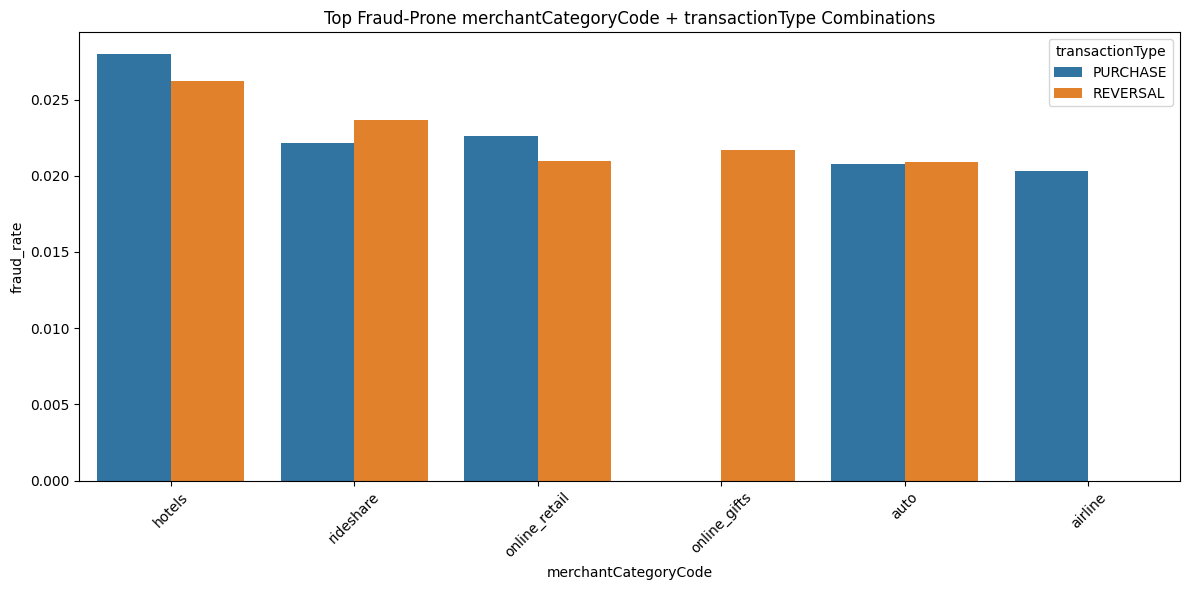

In [44]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_combinations, x="merchantCategoryCode", y="fraud_rate", hue="transactionType")
plt.xticks(rotation=45)
plt.title("Top Fraud-Prone merchantCategoryCode + transactionType Combinations")
plt.tight_layout()
plt.show()


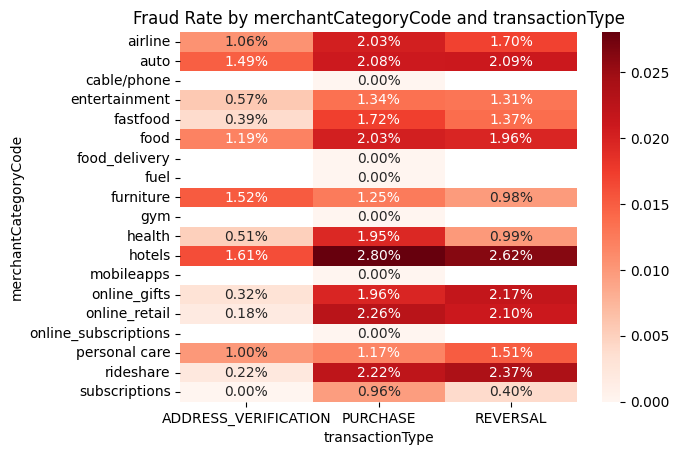

In [45]:
pivot_table = grouped.pivot(index="merchantCategoryCode", columns="transactionType", values="fraud_rate")
sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap="Reds")
plt.title("Fraud Rate by merchantCategoryCode and transactionType")
plt.show()

* Merchant category code (hotels) with purchase transaction type is more prone to fraud transactions(2.80%), followed by combination of hotels and reversal (2.62%).
* Overall, transactions based on hotels are more prone to fraud.
* cable/phone,food_delivery, fuel, gym and online_subscriptions are free from fraud.
* NUmber of fraud transactions are more in online_retails

In [51]:
checking = transaction_df.groupby(["merchantCategoryCode"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum",
    fraud_rate = "mean"
).reset_index()

In [52]:
checking

,merchantCategoryCode,total_transactions,fraud_transaction,fraud_rate
0,airline,9919,198,0.019962
1,auto,10073,208,0.020649
2,cable/phone,1453,0,0.000000
3,entertainment,68655,903,0.013153
4,fastfood,100572,1685,0.016754
5,food,67840,1362,0.020077
6,food_delivery,4936,0,0.000000
7,fuel,22397,0,0.000000
8,furniture,7756,97,0.012506
9,gym,2848,0,0.000000


## what is the average number of days in which customer related to fraud transactions change their address, after committing first fraud transaction?

In [54]:
transaction_df["dateOfLastAddressChange"] = pd.to_datetime(transaction_df["dateOfLastAddressChange"], dayfirst=True)

In [82]:
transaction_df = transaction_df.sort_values(["accountNumber", "transactionDateTime"])

In [55]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]

In [83]:
first_fraud_dates = fraud_df.groupby("accountNumber")["transactionDateTime"].min().reset_index()
first_fraud_dates.columns = ["accountNumber", "first_fraud_date"]

In [57]:
first_fraud_dates

,accountNumber,first_fraud_date
0,100547107,2016-04-02 20:23:39
1,101680180,2016-11-02 13:22:04
2,102307135,2016-12-16 20:57:58
3,102635965,2016-06-08 10:38:24
4,103893403,2016-05-03 14:58:34
...,...,...
2262,997379599,2016-01-26 19:36:10
2263,998480579,2016-02-09 00:56:50
2264,998837644,2016-08-06 10:15:52
2265,999275549,2016-06-19 15:59:45


In [71]:
address_change_date = transaction_df.groupby("accountNumber")["dateOfLastAddressChange"].max().reset_index()

In [72]:
merged = pd.merge(first_fraud_dates, address_change_date, on="accountNumber", how="inner")
merged["days_to_address_change"] = (merged["first_fraud_date"] - merged["dateOfLastAddressChange"]).dt.days

In [73]:
valid_changes = merged[merged["days_to_address_change"] > 0]

In [78]:
average_days = valid_changes["days_to_address_change"].mean()

In [79]:
average_days

np.float64(787.0085836909872)

* The average is very high so it suggests that there is no straight link between fraud and address change.

## Do customers who commit fraud tend to increase their transaction amount shortly before the fraudulent activity?

In [86]:
first_fraud_dates = transaction_df[transaction_df["isFraud"] == 1].groupby("accountNumber")["transactionDateTime"].min()

In [87]:
transaction_df["first_fraud_date"] = transaction_df["accountNumber"].map(first_fraud_dates)

In [88]:
transaction_df["days_before_fraud"] = (transaction_df["first_fraud_date"] - transaction_df["transactionDateTime"]).dt.days

In [90]:
transaction_df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand,first_fraud_date,days_before_fraud
579640,100547107,100547107,2500,2500.00,2016-01-02 01:47:46,64.66,Popeyes #414406,US,US,9.0,...,0.00,True,False,0,1,1,2,Popeyes,2016-04-02 20:23:39,91.0
579641,100547107,100547107,2500,2435.34,2016-01-16 23:35:41,5.31,Popeyes #700785,US,US,80.0,...,64.66,True,False,0,23,1,16,Popeyes,2016-04-02 20:23:39,76.0
579642,100547107,100547107,2500,2430.03,2016-01-17 21:50:04,204.23,Arbys #46046,US,US,2.0,...,69.97,True,False,0,21,1,17,Arbys,2016-04-02 20:23:39,75.0
579643,100547107,100547107,2500,2225.80,2016-01-29 05:19:50,155.28,Shake Shack #968081,US,US,5.0,...,274.20,True,False,0,5,1,29,Shake Shack,2016-04-02 20:23:39,64.0
579644,100547107,100547107,2500,2070.52,2016-01-30 20:49:10,91.14,In-N-Out #27394,US,US,9.0,...,429.48,True,False,0,20,1,30,In-N-Out,2016-04-02 20:23:39,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169923,999985343,999985343,500,292.30,2016-12-16 06:33:54,62.34,Shell Gas #256420,US,US,9.0,...,207.70,True,False,0,6,12,16,Shell Gas,NaT,NaN
169924,999985343,999985343,500,229.96,2016-12-20 00:05:00,68.00,Seattle Times,US,US,5.0,...,270.04,False,False,0,0,12,20,Seattle Times,NaT,NaN
169925,999985343,999985343,500,161.96,2016-12-25 10:58:22,151.42,Washington News,US,US,2.0,...,338.04,False,False,0,10,12,25,Washington News,NaT,NaN
169926,999985343,999985343,500,185.39,2016-12-29 08:21:58,68.66,Shell Gas #256420,US,US,9.0,...,314.61,True,False,0,8,12,29,Shell Gas,NaT,NaN


In [91]:
pre_fraud = transaction_df[(transaction_df["days_before_fraud"] >= 1) & (transaction_df["days_before_fraud"] <= 7)]

In [92]:
early_txns = transaction_df[(transaction_df["days_before_fraud"] > 7)]

In [93]:
pre_fraud

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand,first_fraud_date,days_before_fraud
579653,100547107,100547107,2500,1684.38,2016-03-27 11:16:54,321.36,In-N-Out #186321,US,US,5.0,...,815.62,True,False,0,11,3,27,In-N-Out,2016-04-02 20:23:39,6.0
579654,100547107,100547107,2500,1363.02,2016-03-29 05:01:06,147.13,Subway #344185,US,US,80.0,...,1136.98,True,False,0,5,3,29,Subway,2016-04-02 20:23:39,4.0
579655,100547107,100547107,2500,2500.00,2016-04-01 09:23:38,91.63,Popeyes #327293,US,US,9.0,...,0.00,True,False,0,9,4,1,Popeyes,2016-04-02 20:23:39,1.0
116800,101680180,101680180,15000,11183.03,2016-10-27 04:51:41,40.84,cheapfast.com,US,US,5.0,...,3816.97,False,False,0,4,10,27,cheapfast.com,2016-11-02 13:22:04,6.0
20962,102307135,102307135,20000,18745.98,2016-12-09 23:06:11,31.66,Universe Massage #114220,US,US,2.0,...,1254.02,True,False,0,23,12,9,Universe Massage,2016-12-16 20:57:58,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630937,999275549,999275549,50000,49026.16,2016-06-15 13:39:10,116.16,target.com,US,US,5.0,...,973.84,False,False,0,13,6,15,target.com,2016-06-19 15:59:45,4.0
630938,999275549,999275549,50000,48910.00,2016-06-16 16:41:27,7.66,Lyft,US,US,5.0,...,1090.00,False,False,0,16,6,16,Lyft,2016-06-19 15:59:45,2.0
630939,999275549,999275549,50000,48902.34,2016-06-16 19:36:08,51.80,alibaba.com,US,US,9.0,...,1097.66,False,False,0,19,6,16,alibaba.com,2016-06-19 15:59:45,2.0
630940,999275549,999275549,50000,48850.54,2016-06-17 18:29:29,0.00,oldnavy.com,US,US,9.0,...,1149.46,False,False,0,18,6,17,oldnavy.com,2016-06-19 15:59:45,1.0


In [94]:
early_txns

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day,merchantBrand,first_fraud_date,days_before_fraud
579640,100547107,100547107,2500,2500.00,2016-01-02 01:47:46,64.66,Popeyes #414406,US,US,9.0,...,0.00,True,False,0,1,1,2,Popeyes,2016-04-02 20:23:39,91.0
579641,100547107,100547107,2500,2435.34,2016-01-16 23:35:41,5.31,Popeyes #700785,US,US,80.0,...,64.66,True,False,0,23,1,16,Popeyes,2016-04-02 20:23:39,76.0
579642,100547107,100547107,2500,2430.03,2016-01-17 21:50:04,204.23,Arbys #46046,US,US,2.0,...,69.97,True,False,0,21,1,17,Arbys,2016-04-02 20:23:39,75.0
579643,100547107,100547107,2500,2225.80,2016-01-29 05:19:50,155.28,Shake Shack #968081,US,US,5.0,...,274.20,True,False,0,5,1,29,Shake Shack,2016-04-02 20:23:39,64.0
579644,100547107,100547107,2500,2070.52,2016-01-30 20:49:10,91.14,In-N-Out #27394,US,US,9.0,...,429.48,True,False,0,20,1,30,In-N-Out,2016-04-02 20:23:39,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630931,999275549,999275549,50000,48902.10,2016-05-28 20:13:57,114.99,target.com,US,US,2.0,...,1097.90,False,False,0,20,5,28,target.com,2016-06-19 15:59:45,21.0
630932,999275549,999275549,50000,48787.11,2016-05-31 01:55:48,253.09,walmart.com,US,US,2.0,...,1212.89,False,False,0,1,5,31,walmart.com,2016-06-19 15:59:45,19.0
630933,999275549,999275549,50000,50000.00,2016-06-03 10:11:21,28.91,apple.com,US,US,9.0,...,0.00,False,False,0,10,6,3,apple.com,2016-06-19 15:59:45,16.0
630934,999275549,999275549,50000,49971.09,2016-06-05 16:56:30,284.03,Uber,US,US,9.0,...,28.91,False,False,0,16,6,5,Uber,2016-06-19 15:59:45,13.0


In [106]:
from scipy.stats import mannwhitneyu
t_stat, p_value =mannwhitneyu(pre_fraud["transactionAmount"], early_txns["transactionAmount"], alternative='two-sided')


In [107]:
t_stat

np.float64(320653834.0)

In [108]:
p_value

np.float64(0.3769893804826089)

In [109]:
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in transaction amounts between pre-fraud and early transactions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in transaction amounts between pre-fraud and early transactions.")

Fail to reject the null hypothesis: There is no significant difference in transaction amounts between pre-fraud and early transactions.


<Axes: xlabel='transactionAmount', ylabel='Count'>

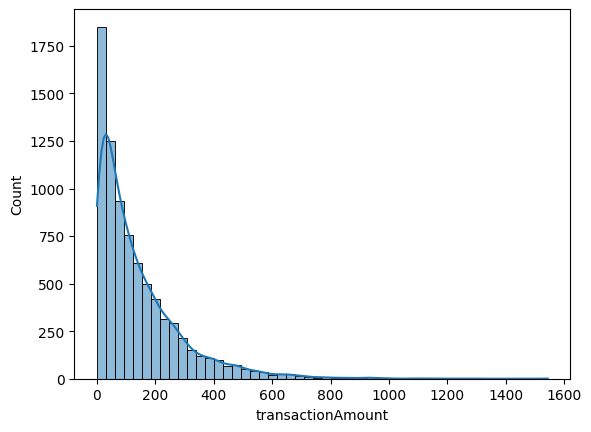

In [104]:
sns.histplot(pre_fraud["transactionAmount"], bins=50, kde=True)

<Axes: xlabel='transactionAmount', ylabel='Count'>

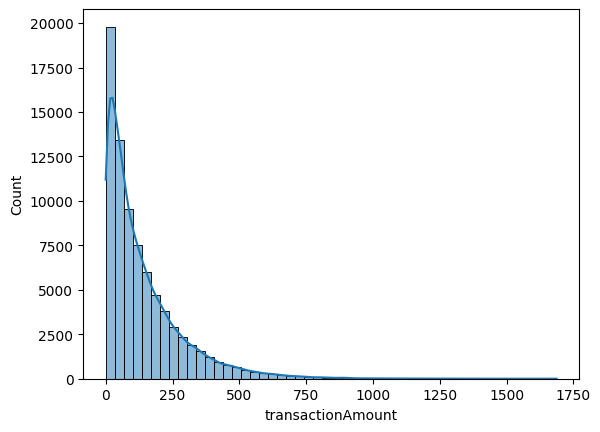

In [110]:
sns.histplot(early_txns["transactionAmount"], bins=50, kde=True)

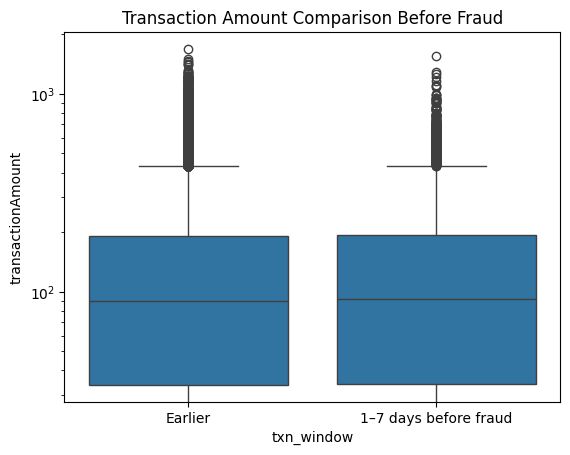

In [105]:
transaction_df["txn_window"] = "other"
transaction_df.loc[pre_fraud.index, "txn_window"] = "1–7 days before fraud"
transaction_df.loc[early_txns.index, "txn_window"] = "Earlier"

# Plot
sns.boxplot(data=transaction_df[transaction_df["txn_window"] != "other"], 
            x="txn_window", y="transactionAmount")
plt.yscale("log")  # if there are large outliers
plt.title("Transaction Amount Comparison Before Fraud")
plt.show()

## which posEntryMode and posConditionCode has the highest fraud rate?

In [4]:
fraud_df = transaction_df[transaction_df["isFraud"] == 1]

In [7]:
grouped = transaction_df.groupby(["posEntryMode"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transactions = "sum"
).reset_index()

grouped ["fraud_rate"] = (grouped["fraud_transactions"] / grouped["total_transactions"])
grouped

,posEntryMode,total_transactions,fraud_transactions,fraud_rate
0,2.0,160353,3036,0.018933
1,5.0,255283,2067,0.008097
2,9.0,192927,5339,0.027674
3,80.0,12899,188,0.014575
4,90.0,16204,326,0.020118


In [8]:
grouped = transaction_df.groupby(["posConditionCode"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transactions = "sum"
).reset_index()

grouped ["fraud_rate"] = (grouped["fraud_transactions"] / grouped["total_transactions"])
grouped

,posConditionCode,total_transactions,fraud_transactions,fraud_rate
0,1.0,510982,9105,0.017819
1,8.0,120736,1635,0.013542
2,99.0,5948,216,0.036315


In [17]:
grouped = transaction_df.groupby(["posEntryMode","posConditionCode"])["isFraud"].agg(
    total_transactions = "count",
    fraud_transactions = "sum"
).reset_index()
grouped ["fraud_rate"] = (grouped["fraud_transactions"] / grouped["total_transactions"])
grouped

,posEntryMode,posConditionCode,total_transactions,fraud_transactions,fraud_rate
0,2.0,1.0,128560,2534,0.019711
1,2.0,8.0,30342,451,0.014864
2,2.0,99.0,1451,51,0.035148
3,5.0,1.0,204434,1690,0.008267
4,5.0,8.0,48476,344,0.007096
5,5.0,99.0,2373,33,0.013906
6,9.0,1.0,154694,4464,0.028857
7,9.0,8.0,36434,767,0.021052
8,9.0,99.0,1799,108,0.060033
9,80.0,1.0,10333,149,0.014420


* posEntryMode (9.0) has high rate of fraud transactions.
* posConditionCode (99.0) has high rate of fraud transactions.
* Combination of (9.0 and 99.0) has very high fraud rate of about 10.5%.

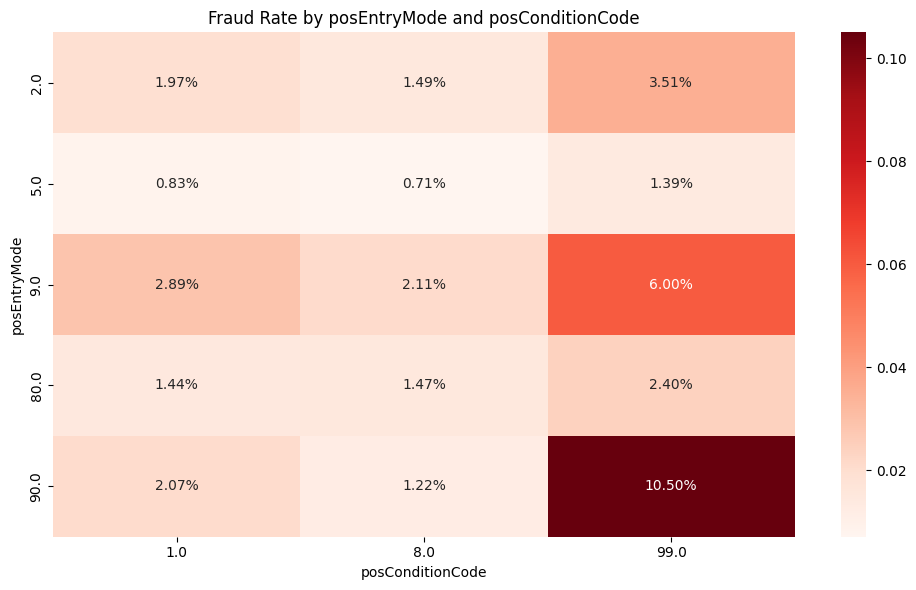

In [18]:
heatmap_data = grouped.pivot(index='posEntryMode', columns='posConditionCode', values='fraud_rate')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="Reds")
plt.title('Fraud Rate by posEntryMode and posConditionCode')
plt.ylabel('posEntryMode')
plt.xlabel('posConditionCode')
plt.tight_layout()
plt.show()

## Are specific merchants  involved in more fraud?

In [29]:
grouped = transaction_df.groupby("merchantBrand")['isFraud'].agg(
    total_transactions = "count",
    fraud_transactions = "sum",
    fraud_rate = "mean"
).reset_index()
grouped = grouped.sort_values(by="fraud_rate", ascending=False).head(10)
grouped["fraud_rate"] = grouped["fraud_rate"] * 100

In [30]:
grouped

,merchantBrand,total_transactions,fraud_transactions,fraud_rate
69,Fast Repair,521,90,17.274472
85,Hyatt House,3427,346,10.096294
66,Ethan Allen,551,30,5.444646
5,34th BBQ,5896,239,4.053596
33,Boston Diner,720,28,3.888889
88,John's Bistro,748,29,3.877005
40,Convenient Auto Services,516,20,3.875969
23,Best Bistro,1417,53,3.740296
95,Marriott Hotels,109,4,3.669725
16,American Airlines,1971,71,3.602232


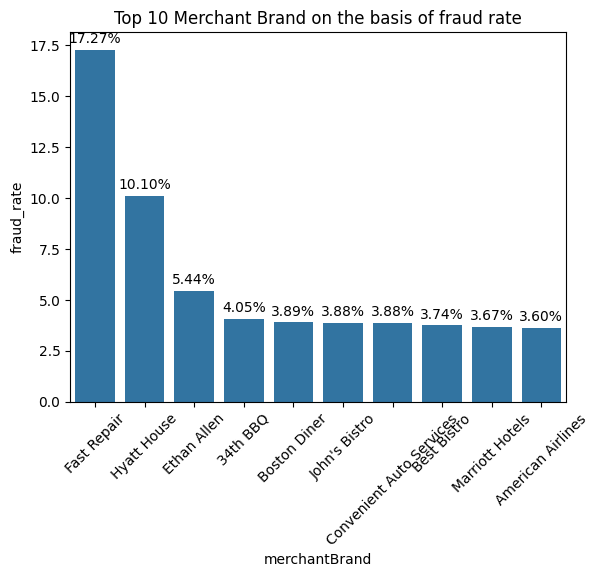

In [31]:
ax = sns.barplot(data=grouped, x="merchantBrand", y="fraud_rate")
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%', label_type='edge', fontsize=10, color='black', padding=3)
plt.xticks(rotation=45)
plt.title("Top 10 Merchant Brand on the basis of fraud rate")
plt.show()

* Fast Repair has high fraud rate i.e 17.27% followed by Hyatt House (10.10%)


## At which day do specific merchant brands see unusually high fraud rates? (Fast Repair, Hyatt House, Ethan Allen)

In [86]:
transaction_df["day_of_week"] = transaction_df["transactionDateTime"].dt.day_name()

In [87]:
grouped = transaction_df.groupby(["merchantBrand","day_of_week"])['isFraud'].agg(
    total_transactions = "count",
    fraud_transactions = "sum",
    fraud_rate = "mean"
).reset_index()
grouped.sort_values(by=["fraud_transactions","fraud_rate"], ascending=False).head(10)

,merchantBrand,day_of_week,total_transactions,fraud_transactions,fraud_rate
662,Lyft,Tuesday,3674,87,0.023680
1098,Uber,Saturday,3587,85,0.023697
663,Lyft,Wednesday,3614,85,0.023520
1097,Uber,Monday,3486,84,0.024096
1101,Uber,Tuesday,3656,83,0.022702
1096,Uber,Friday,3621,81,0.022370
660,Lyft,Sunday,3631,77,0.021206
1100,Uber,Thursday,3664,77,0.021015
659,Lyft,Saturday,3568,76,0.021300
661,Lyft,Thursday,3537,74,0.020922


In [88]:
top_5_fraud_merchants =["Fast Repair","Hyatt House","Ethan Allen","34th BBQ","Boston Diner"]

In [89]:
filterd = grouped[grouped["merchantBrand"].isin(top_5_fraud_merchants)]

In [90]:
filterd.groupby(["merchantBrand",'day_of_week']).agg(
    fraud_rate = ("fraud_rate","mean")
).reset_index()

,merchantBrand,day_of_week,fraud_rate
0,34th BBQ,Friday,0.043011
1,34th BBQ,Monday,0.039616
2,34th BBQ,Saturday,0.040323
3,34th BBQ,Sunday,0.034731
4,34th BBQ,Thursday,0.040964
5,34th BBQ,Tuesday,0.045949
6,34th BBQ,Wednesday,0.039261
7,Boston Diner,Friday,0.027778
8,Boston Diner,Monday,0.027027
9,Boston Diner,Saturday,0.058824


In [91]:
idx = filterd.groupby(["merchantBrand"])['fraud_rate'].idxmax()

In [92]:
top_fraud_days = filterd.loc[idx]
top_fraud_days

,merchantBrand,day_of_week,total_transactions,fraud_transactions,fraud_rate
40,34th BBQ,Tuesday,827,38,0.045949
233,Boston Diner,Saturday,102,6,0.058824
462,Ethan Allen,Monday,78,7,0.089744
488,Fast Repair,Wednesday,65,16,0.246154
596,Hyatt House,Saturday,451,53,0.117517


In [93]:
top_fraud_days

,merchantBrand,day_of_week,total_transactions,fraud_transactions,fraud_rate
40,34th BBQ,Tuesday,827,38,0.045949
233,Boston Diner,Saturday,102,6,0.058824
462,Ethan Allen,Monday,78,7,0.089744
488,Fast Repair,Wednesday,65,16,0.246154
596,Hyatt House,Saturday,451,53,0.117517


* Fast Repair has almost 50% fraud transactions in 28th day.
* Fast Repair has almost 25% fraud transactions in wednesday and Hyatt House has 11.7% fraud transactions in Saturday. 


## Perform hypothesis testing between all numerical columns and dependent column.

In [94]:
integer_columns = transaction_df.select_dtypes(include=['int64']).columns

In [95]:
integer_columns

Index(['accountNumber', 'customerId', 'creditLimit', 'cardCVV', 'enteredCVV',
       'cardLast4Digits', 'cross_border_count', 'txn_hour', 'txn_month',
       'txn_day'],
      dtype='object')

In [97]:
integer_columns = ["availableMoney","transactionAmount","currentBalance"]
transaction_df[integer_columns].describe()

,availableMoney,transactionAmount,currentBalance
count,637666.000000,637666.000000,637666.000000
mean,6652.259023,135.184642,4044.940608
std,9227.524734,147.062958,5946.938952
min,-1244.930000,0.000000,0.000000
25%,1115.270000,32.320000,502.892500
50%,3577.325000,85.830000,2152.275000
75%,8163.632500,189.060000,5006.452500
max,50000.000000,1825.250000,47496.500000


In [100]:
#mannwhitneyu test
from scipy.stats import mannwhitneyu
# Separate the two groups
fraud_available_money = transaction_df[transaction_df["isFraud"] == 1][integer_columns]
non_fraud_available_money = transaction_df[transaction_df["isFraud"] == 0][integer_columns]
for column in integer_columns:
    stat, p_value = mannwhitneyu(fraud_available_money[column], non_fraud_available_money[column], alternative='two-sided')
    print(f"Mann-Whitney U Test for {column}: statistic = {stat}, p-value = {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print(f"Result: Significant difference between fraud and non-fraud {column} distributions (reject H0)")
        print("**********************************************************************")
    else:
        print(f"Result: No significant difference between fraud and non-fraud {column} distributions (fail to reject H0)")
        print("**********************************************************************")

Mann-Whitney U Test for availableMoney: statistic = 3468952400.0, p-value = 0.0606495946941368
Result: No significant difference between fraud and non-fraud availableMoney distributions (fail to reject H0)
**********************************************************************
Mann-Whitney U Test for transactionAmount: statistic = 4720584149.5, p-value = 0.0
Result: Significant difference between fraud and non-fraud transactionAmount distributions (reject H0)
**********************************************************************
Mann-Whitney U Test for currentBalance: statistic = 3637438179.0, p-value = 1.0467824297027972e-26
Result: Significant difference between fraud and non-fraud currentBalance distributions (reject H0)
**********************************************************************


* transactionAmount and currentBalance can be strong candidate feature for further modeling.

## Are accounts with frauds opened in certain months/seasons?

In [4]:
transaction_df[transaction_df["isFraud"] == 1]["accountOpenDate"].describe()

count                            10956
mean     2014-01-06 15:12:33.121577216
min                2000-11-16 00:00:00
25%                2013-05-13 00:00:00
50%                2014-06-07 12:00:00
75%                2015-05-28 00:00:00
max                2015-12-31 00:00:00
Name: accountOpenDate, dtype: object

In [ ]:
transaction_df["account_open_day"] = transaction_df["accountOpenDate"].dt.day_name()
transaction_df["account_open_day"].value_counts()

account_open_day
Friday       108090
Thursday     101016
Saturday      93407
Wednesday     91207
Monday        85589
Tuesday       84740
Sunday        73617
Name: count, dtype: int64

In [6]:
transaction_df[transaction_df["isFraud"] == 1]["account_open_day"].value_counts()

account_open_day
Friday       1909
Thursday     1820
Saturday     1673
Wednesday    1601
Monday       1339
Tuesday      1337
Sunday       1277
Name: count, dtype: int64

In [10]:
grouped = transaction_df.groupby("account_open_day")["isFraud"].agg(
    total_transactions = "count",
    fraud_transaction = "sum",
    fraud_rate = "mean"
).reset_index()
grouped["fraud_rate"] = grouped["fraud_rate"] * 100

In [11]:
grouped

,account_open_day,total_transactions,fraud_transaction,fraud_rate
0,Friday,108090,1909,1.766121
1,Monday,85589,1339,1.564453
2,Saturday,93407,1673,1.791086
3,Sunday,73617,1277,1.734654
4,Thursday,101016,1820,1.801695
5,Tuesday,84740,1337,1.577767
6,Wednesday,91207,1601,1.755348


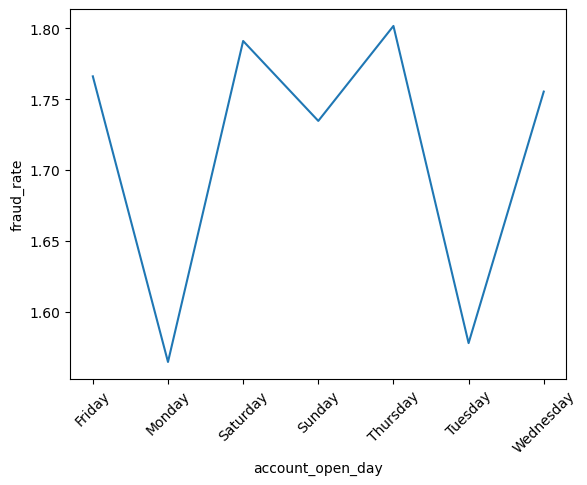

In [13]:
#visualize fraud rate by account open day

sns.lineplot(grouped, x = "account_open_day", y = "fraud_rate")
plt.xticks(rotation=45)
plt.show()

In [14]:
#mannwhitneyu test
from scipy.stats import mannwhitneyu
# Separate the two groups
fraud_available_money = transaction_df[transaction_df["isFraud"] == 1]["accountOpenDate"]
non_fraud_available_money = transaction_df[transaction_df["isFraud"] == 0]["accountOpenDate"]
stat, p_value = mannwhitneyu(fraud_available_money, non_fraud_available_money, alternative='two-sided')
print(f"Mann-Whitney U Test statistic = {stat}, p-value = {p_value}")
alpha = 0.05
if p_value < alpha:
    print("Result: Significant difference between fraud and non-fraud account open date distributions (reject H0)")
else:
    print("Result: No significant difference between fraud and non-fraud account open date distributions (fail to reject H0)")

Mann-Whitney U Test statistic = 3428438615.0, p-value = 0.8064991502726349
Result: No significant difference between fraud and non-fraud account open date distributions (fail to reject H0)


In [16]:
from scipy.stats import chi2_contingency
#chi-square test between account open day and fraud
contingency_table = pd.crosstab(transaction_df["account_open_day"], transaction_df["isFraud"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square test statistic = {chi2}, p-value = {p}")
alpha = 0.05
if p < alpha:
    print("Result: Significant association between account open day and fraud (reject H0)")
else:
    print("Result: No significant association between account open day and fraud (fail to reject H0)")

Chi-square test statistic = 31.320157800587232, p-value = 2.2019129434267405e-05
Result: Significant association between account open day and fraud (reject H0)


In [17]:
contingency_table

isFraud,False,True
account_open_day,,
Friday,106181,1909
Monday,84250,1339
Saturday,91734,1673
Sunday,72340,1277
Thursday,99196,1820
Tuesday,83403,1337
Wednesday,89606,1601


* Significant association between account open day and fraud
* No significant difference between fraud and non-fraud account open date distributions
* Account opened in thursday are more active in fraud transactions in compared to account opened in other days, but difference margin is not so high.

## nf

### Does length of cardCVV number impact fraud rate?

In [8]:
transaction_df["cardLast4Digits"].value_counts()

cardLast4Digits
1789    9977
5658    8369
0       6697
5335    5509
4062    5115
        ... 
9606       1
9071       1
2335       1
6945       1
2203       1
Name: count, Length: 5134, dtype: int64

In [4]:
transaction_df["cardCVV"].value_counts()

cardCVV
633    11293
746     8838
625     7581
312     6531
986     6418
       ...  
384       61
981       54
500       49
199       37
862       19
Name: count, Length: 899, dtype: int64

In [9]:
transaction_df[transaction_df["cardCVV"].astype(str).str.len() != 3]["cardCVV"].value_counts()

Series([], Name: count, dtype: int64)

Since cardCVV number is of 4 digit for all rows so we cant analyze based on length of cardCVV number. 

In [10]:
transaction_df["enteredCVV"].value_counts()

enteredCVV
633    11193
746     8768
625     7516
312     6472
986     6353
       ...  
45         1
22         1
44         1
53         1
4          1
Name: count, Length: 980, dtype: int64

### Does length of Entered cardCVV number impact fraud rate?

In [14]:
filtered = transaction_df[transaction_df["enteredCVV"].astype(str).str.len() != 3]

In [15]:
filtered.shape

(213, 27)

In [16]:
filtered[filtered["isFraud"] == 1]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch,cross_border_count,txn_hour,txn_month,txn_day
27007,383028435,383028435,15000,9228.44,2016-01-24 02:58:11,169.58,alibaba.com,US,US,9.0,...,5391,PURCHASE,True,5771.56,False,False,0,2,1,24
135150,890271201,890271201,5000,2033.83,2016-02-01 08:35:13,386.67,Quizno's #26888,US,US,9.0,...,4769,PURCHASE,True,2966.17,True,False,0,8,2,1
141978,903360157,903360157,50000,26353.13,2016-12-30 13:20:21,193.27,American Airlines,US,US,2.0,...,7104,PURCHASE,True,23646.87,False,False,0,13,12,30
207509,376921747,376921747,5000,4397.96,2016-12-01 14:49:08,414.26,ebay.com,US,US,5.0,...,3502,PURCHASE,True,602.04,False,False,0,14,12,1
391028,711990261,711990261,1000,617.15,2016-01-26 03:43:03,139.17,Blue Mountain eCards,US,US,5.0,...,5360,PURCHASE,True,382.85,False,False,0,3,1,26
539007,297952999,297952999,15000,5736.75,2016-03-26 09:41:19,212.05,oldnavy.com,US,US,9.0,...,2386,PURCHASE,True,9263.25,False,False,0,9,3,26
596379,700321326,700321326,2500,129.20,2016-01-15 09:43:03,122.88,Rodeway Inn #982555,US,US,2.0,...,4019,PURCHASE,True,2370.80,True,False,0,9,1,15


In [17]:
fraud_percentage = (filtered[filtered["isFraud"] == 1].shape[0] / filtered.shape[0]) * 100

In [18]:
fraud_percentage

3.286384976525822

As we can see that there is missing of hundredth place digit in entered CVV.(Length < 3)
There is only 3% of fraud related to enteredCVV length < 3. so there is no significant association of enteredCVV length < 3, to the fraud transactions.

### Association between cardCVV and EnteredcardCVV with fraud?

In [26]:
# Chi-square test
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(transaction_df["cardCVV"].astype(str), transaction_df["isFraud"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square test statistic = {chi2}, p-value = {p}")
alpha = 0.05
if p < alpha:
    print("Result: Significant association between cardCVV and fraud (reject H0)")
else:
    print("Result: No significant association between cardCVV and fraud (fail to reject H0)")   

Chi-square test statistic = 5418.223525891453, p-value = 0.0
Result: Significant association between cardCVV and fraud (reject H0)


In [27]:
contingency_table

isFraud,False,True
cardCVV,,
100,428,2
101,112,4
102,322,19
103,71,6
104,1745,14
...,...,...
994,305,11
995,256,3
996,133,2


- Significant association between cardCVV and fraud based on chi-square test.
- Significant association between enteredCVV and fraud based on chi-square test.

## next